In [1]:
# Install packages #
# !pip install numpy
# !pip install matplotlib
# !pip install torch
# !pip install xlrd
# !pip install pandas

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset

In [3]:
# Loading training data
dataset = pd.read_csv("bmi_train.csv")
dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
dataset = dataset.to_numpy()

# Splitting off 80% of data for training, 20% for validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, [0,1,2]]
y_train = dataset[:train_split, 3]
X_test = dataset[train_split:, [0,1,2]]
y_test = dataset[train_split:, 3]

# Loading prediction data
prediction_dataset = pd.read_csv("bmi_validation.csv")
prediction_dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
X_prediction = prediction_dataset.to_numpy()

# Normalize data set
X_train_normalized = (X_train - X_train.min(0)) / (X_train.max(0) - X_train.min(0))
X_test_normalized = (X_test - X_test.min(0)) / (X_test.max(0) - X_test.min(0))
X_prediction_normalized = (X_prediction - X_prediction.min(0)) / (X_prediction.max(0) - X_prediction.min(0))

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
X_prediction_tensor = torch.from_numpy(X_prediction_normalized)

Custom SGD

Learned parameters:
w0 = 0.060808857709234714
w1 = -2.1334616790571426
w2 = 3.847422443386162
b = 2.8643211189596514


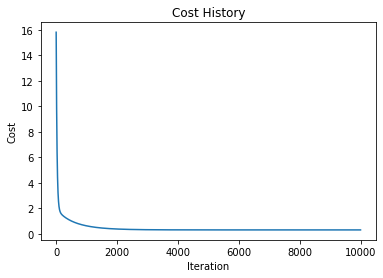

In [4]:
# Vanilia Gradient Descent Algorithms
def gradient_descent(X, y, learning_rate, num_iterations):
    num_samples, num_features = X.shape
    
    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []
    
    for _ in range(num_iterations):
        # Calculate predictions
        y_pred = np.dot(X, w) + b
        
        # Calculate the difference between predictions and actual values
        error = y_pred - y
        
        # Calculate the gradient
        w_gradient = (1/num_samples) * np.dot(X.T, error)
        b_gradient = (1/num_samples) * np.sum(error)
        
        # Update theta using the learning rate and gradient
        w -= learning_rate * w_gradient
        b -= learning_rate * b_gradient
        
        # Calculate the cost (mean squared error)
        cost = np.mean(np.square(error))
        cost_history.append(cost)
    
    return w, b, cost_history

# Train the model using gradient descent
learning_rate = 0.01
num_iterations = 10000
w, b, cost_history = gradient_descent(X_train_normalized, y_train, learning_rate, num_iterations)

# Print the learned parameters
print("Learned parameters:")

for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

Learned parameters:
w0 = 0.061038568149536135
w1 = -2.1365639995641903
w2 = 3.847405053560641
b = 2.869233452882177


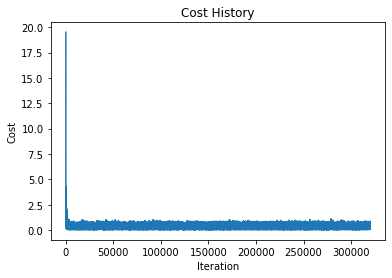

In [5]:
# Stochastic Gradien Descent Algorithms
def stochastic_gradient_descent(X, y, learning_rate, num_epochs, batch_size):
    num_samples, num_features = X.shape
    num_batches = num_samples // batch_size

    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for batch in range(num_batches):
            # Select the current batch
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Calculate predictions
            y_pred = np.dot(X_batch, w) + b

            # Calculate the difference between predictions and actual values
            error = y_pred - y_batch

            # Calculate the gradients
            w_gradient = (1 / batch_size) * np.dot(X_batch.T, error)
            b_gradient = (1 / batch_size) * np.sum(error)

            # Update weights and bias
            w -= learning_rate * w_gradient
            b -= learning_rate * b_gradient

            # Calculate the cost (mean squared error)
            cost = np.mean(np.square(error))
            cost_history.append(cost)
            
    return w, b, cost_history

# Train the model using stochastic gradient descent
learning_rate = 0.01
num_epochs = 10000
batch_size = 10
w, b, cost_history = stochastic_gradient_descent(X_train_normalized, y_train, learning_rate, num_epochs, batch_size)

# Print the learned parameters
print("Learned parameters:")
for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

Pytorch SGD

In [6]:
torch.manual_seed(42)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.zeros(3, 1, # tensor size (3,1) for 3 variables and 1 output
                                               dtype=torch.float),
                                  requires_grad=True)  #we can update this value with gradient descent
        self.bias = nn.Parameter(torch.zeros(1,
                                            dtype=torch.float),
                                requires_grad=True)
    # Define one computation step as forward
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.transpose(self.weights, 0, 1) * x + self.bias #regression formula

In [7]:
# Create instance of model
model_0 = LinearRegressionModel()

# Check nn.Parameters in the nn.Module subclass created
list(model_0.parameters())

[Parameter containing:
 tensor([[0.],
         [0.],
         [0.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

In [8]:
# Create loss function (Mean absolute error)
loss_fn = nn.MSELoss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), #parameters of target model to optimize
                           lr=0.01) #learning rate, how much optimizer should change the parameters each step

In [9]:
# ACTUAL TRAINING OF THE MODEL

torch.manual_seed(42)
# no. of times the model will pass over the training data
epochs = 50000

# Create empty loss list to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### TRAINING!!!
    
    # Put model in training mode
    model_0.train()
    
    # 1. Forward pass on train data
    y_pred = model_0(X_train_tensor) # weight prediction
    # calculated index prediction
    index_pred = torch.sum(torch.mul(X_train_tensor, y_pred), dim=1) + model_0.bias #sum product of weight and data
        
    # 2. Calculate loss from prediction
    loss = loss_fn(index_pred.double(), y_train_tensor.double())
    
    # 3. Zero grad of optimizer
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Progress the optimizer
    optimizer.step()
    
    ### TESTING ACCURACY!!!
    
    # Put model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test_tensor)
        
        # 2. Calculate loss on test data
        test_sum_prod = torch.sum(torch.mul(X_test_tensor, test_pred), dim=1) + model_0.bias
        test_loss = loss_fn(test_sum_prod, y_test_tensor)
        
        # Print out what is happening (each 10 steps)
        if epoch % 1 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
    
    

Epoch: 0 | MAE Train Loss: 15.80625 | MAE Test Loss: 12.244346394535613 
Epoch: 1 | MAE Train Loss: 12.097977166527667 | MAE Test Loss: 9.519757819975723 
Epoch: 2 | MAE Train Loss: 9.406777537929964 | MAE Test Loss: 7.5351409392734325 
Epoch: 3 | MAE Train Loss: 7.453224524927168 | MAE Test Loss: 6.088252695956648 
Epoch: 4 | MAE Train Loss: 6.034662509015179 | MAE Test Loss: 5.0322527097664445 
Epoch: 5 | MAE Train Loss: 5.0041140945370195 | MAE Test Loss: 4.2605070524628905 
Epoch: 6 | MAE Train Loss: 4.254983164151073 | MAE Test Loss: 3.695562027486068 
Epoch: 7 | MAE Train Loss: 3.7099594883252918 | MAE Test Loss: 3.2811466322701177 
Epoch: 8 | MAE Train Loss: 3.312974216251581 | MAE Test Loss: 2.976366017623884 
Epoch: 9 | MAE Train Loss: 3.0233621345906996 | MAE Test Loss: 2.7514914684639757 
Epoch: 10 | MAE Train Loss: 2.8116312264876924 | MAE Test Loss: 2.5849020034068486 
Epoch: 11 | MAE Train Loss: 2.656391563427617 | MAE Test Loss: 2.4608667622588927 
Epoch: 12 | MAE Train 

Epoch: 249 | MAE Train Loss: 1.3382091644808112 | MAE Test Loss: 1.1978443666409773 
Epoch: 250 | MAE Train Loss: 1.3358624893263245 | MAE Test Loss: 1.1955926575250735 
Epoch: 251 | MAE Train Loss: 1.3335242252154595 | MAE Test Loss: 1.1933497502778327 
Epoch: 252 | MAE Train Loss: 1.3311943288400205 | MAE Test Loss: 1.1911156148662427 
Epoch: 253 | MAE Train Loss: 1.3288727876003101 | MAE Test Loss: 1.1888901900909574 
Epoch: 254 | MAE Train Loss: 1.3265595295085 | MAE Test Loss: 1.1866734517554607 
Epoch: 255 | MAE Train Loss: 1.3242545497335256 | MAE Test Loss: 1.1844653680356543 
Epoch: 256 | MAE Train Loss: 1.3219578027581185 | MAE Test Loss: 1.1822658802911157 
Epoch: 257 | MAE Train Loss: 1.3196692504832743 | MAE Test Loss: 1.180074949729905 
Epoch: 258 | MAE Train Loss: 1.3173888420693607 | MAE Test Loss: 1.1778925398070708 
Epoch: 259 | MAE Train Loss: 1.3151165428415865 | MAE Test Loss: 1.1757186117446001 
Epoch: 260 | MAE Train Loss: 1.3128523182599534 | MAE Test Loss: 1.17

Epoch: 520 | MAE Train Loss: 0.9191578776035552 | MAE Test Loss: 0.8120307955233713 
Epoch: 521 | MAE Train Loss: 0.9181722394790244 | MAE Test Loss: 0.8111779133178896 
Epoch: 522 | MAE Train Loss: 0.9171894250408472 | MAE Test Loss: 0.8103278453801114 
Epoch: 523 | MAE Train Loss: 0.9162094043162913 | MAE Test Loss: 0.8094805811782619 
Epoch: 524 | MAE Train Loss: 0.9152322072294687 | MAE Test Loss: 0.8086361069736459 
Epoch: 525 | MAE Train Loss: 0.9142578142140501 | MAE Test Loss: 0.8077944022041781 
Epoch: 526 | MAE Train Loss: 0.9132861773982895 | MAE Test Loss: 0.8069554700872968 
Epoch: 527 | MAE Train Loss: 0.9123173297745206 | MAE Test Loss: 0.8061192532175667 
Epoch: 528 | MAE Train Loss: 0.9113512296964892 | MAE Test Loss: 0.8052858286605211 
Epoch: 529 | MAE Train Loss: 0.9103878978614386 | MAE Test Loss: 0.8044551020841155 
Epoch: 530 | MAE Train Loss: 0.9094272988418977 | MAE Test Loss: 0.8036271321903881 
Epoch: 531 | MAE Train Loss: 0.9084694385350469 | MAE Test Loss: 

Epoch: 797 | MAE Train Loss: 0.7268800465028786 | MAE Test Loss: 0.6543865221011117 
Epoch: 798 | MAE Train Loss: 0.7264033549826224 | MAE Test Loss: 0.6540233708772214 
Epoch: 799 | MAE Train Loss: 0.7259278248973737 | MAE Test Loss: 0.6536612155793 
Epoch: 800 | MAE Train Loss: 0.7254534067613805 | MAE Test Loss: 0.6533001633710099 
Epoch: 801 | MAE Train Loss: 0.7249801401695279 | MAE Test Loss: 0.6529401478322846 
Epoch: 802 | MAE Train Loss: 0.7245080139416522 | MAE Test Loss: 0.652581119376676 
Epoch: 803 | MAE Train Loss: 0.7240369921570291 | MAE Test Loss: 0.6522231307138507 
Epoch: 804 | MAE Train Loss: 0.7235671190336308 | MAE Test Loss: 0.6518662168539567 
Epoch: 805 | MAE Train Loss: 0.7230983782209179 | MAE Test Loss: 0.651510281218349 
Epoch: 806 | MAE Train Loss: 0.7226307343462682 | MAE Test Loss: 0.6511553674739476 
Epoch: 807 | MAE Train Loss: 0.7221642183227764 | MAE Test Loss: 0.6508015362391989 
Epoch: 808 | MAE Train Loss: 0.721698836074668 | MAE Test Loss: 0.6504

Epoch: 1085 | MAE Train Loss: 0.6261904739369842 | MAE Test Loss: 0.5822143760128337 
Epoch: 1086 | MAE Train Loss: 0.6259389775530236 | MAE Test Loss: 0.5820474506405295 
Epoch: 1087 | MAE Train Loss: 0.6256879881158425 | MAE Test Loss: 0.5818809275156216 
Epoch: 1088 | MAE Train Loss: 0.6254375046566027 | MAE Test Loss: 0.5817147894980438 
Epoch: 1089 | MAE Train Loss: 0.6251875199026614 | MAE Test Loss: 0.5815491609342149 
Epoch: 1090 | MAE Train Loss: 0.6249380699779584 | MAE Test Loss: 0.5813839312292979 
Epoch: 1091 | MAE Train Loss: 0.6246891230807303 | MAE Test Loss: 0.5812190832499129 
Epoch: 1092 | MAE Train Loss: 0.6244406719624979 | MAE Test Loss: 0.5810546763856493 
Epoch: 1093 | MAE Train Loss: 0.6241927564659073 | MAE Test Loss: 0.5808906649532444 
Epoch: 1094 | MAE Train Loss: 0.6239453410546304 | MAE Test Loss: 0.5807270318262573 
Epoch: 1095 | MAE Train Loss: 0.6236984185043647 | MAE Test Loss: 0.5805637918999993 
Epoch: 1096 | MAE Train Loss: 0.6234519941372716 | MAE

Epoch: 1367 | MAE Train Loss: 0.5716467651781325 | MAE Test Loss: 0.5479922653824799 
Epoch: 1368 | MAE Train Loss: 0.5715000121373439 | MAE Test Loss: 0.5479060257166612 
Epoch: 1369 | MAE Train Loss: 0.5713535263531122 | MAE Test Loss: 0.5478199237582476 
Epoch: 1370 | MAE Train Loss: 0.5712072911221318 | MAE Test Loss: 0.5477340665254862 
Epoch: 1371 | MAE Train Loss: 0.5710613289256449 | MAE Test Loss: 0.547648328335581 
Epoch: 1372 | MAE Train Loss: 0.5709156146390663 | MAE Test Loss: 0.5475627470160388 
Epoch: 1373 | MAE Train Loss: 0.5707701708040546 | MAE Test Loss: 0.5474774433073776 
Epoch: 1374 | MAE Train Loss: 0.5706249694585609 | MAE Test Loss: 0.5473922937152504 
Epoch: 1375 | MAE Train Loss: 0.5704800407427759 | MAE Test Loss: 0.5473072629818123 
Epoch: 1376 | MAE Train Loss: 0.5703353551842099 | MAE Test Loss: 0.5472225450136621 
Epoch: 1377 | MAE Train Loss: 0.5701909368134687 | MAE Test Loss: 0.5471379431756918 
Epoch: 1378 | MAE Train Loss: 0.5700467638070739 | MAE 

Epoch: 1649 | MAE Train Loss: 0.5388033953363568 | MAE Test Loss: 0.5295509051132182 
Epoch: 1650 | MAE Train Loss: 0.5387119967327644 | MAE Test Loss: 0.5295021060053399 
Epoch: 1651 | MAE Train Loss: 0.5386207330154524 | MAE Test Loss: 0.5294533363724163 
Epoch: 1652 | MAE Train Loss: 0.5385296120285415 | MAE Test Loss: 0.5294047758424106 
Epoch: 1653 | MAE Train Loss: 0.538438648125334 | MAE Test Loss: 0.529356224816086 
Epoch: 1654 | MAE Train Loss: 0.5383478238344491 | MAE Test Loss: 0.5293078358264754 
Epoch: 1655 | MAE Train Loss: 0.5382571323405994 | MAE Test Loss: 0.5292594754120687 
Epoch: 1656 | MAE Train Loss: 0.5381665827603733 | MAE Test Loss: 0.529211154515843 
Epoch: 1657 | MAE Train Loss: 0.5380761920282987 | MAE Test Loss: 0.5291630108809138 
Epoch: 1658 | MAE Train Loss: 0.5379859374405316 | MAE Test Loss: 0.5291148951180084 
Epoch: 1659 | MAE Train Loss: 0.5378958241389709 | MAE Test Loss: 0.5290669562307712 
Epoch: 1660 | MAE Train Loss: 0.5378058466000499 | MAE Te

Epoch: 1956 | MAE Train Loss: 0.5164120562894011 | MAE Test Loss: 0.5180348396466945 
Epoch: 1957 | MAE Train Loss: 0.5163545633906259 | MAE Test Loss: 0.5180064137711101 
Epoch: 1958 | MAE Train Loss: 0.5162971499474418 | MAE Test Loss: 0.5179781128455305 
Epoch: 1959 | MAE Train Loss: 0.5162398146798839 | MAE Test Loss: 0.5179497933893576 
Epoch: 1960 | MAE Train Loss: 0.51618257377317 | MAE Test Loss: 0.5179215783088297 
Epoch: 1961 | MAE Train Loss: 0.5161254078431587 | MAE Test Loss: 0.5178933182810896 
Epoch: 1962 | MAE Train Loss: 0.5160683209705296 | MAE Test Loss: 0.5178652089575309 
Epoch: 1963 | MAE Train Loss: 0.5160113269298822 | MAE Test Loss: 0.5178370544579707 
Epoch: 1964 | MAE Train Loss: 0.5159544117352806 | MAE Test Loss: 0.5178090243097275 
Epoch: 1965 | MAE Train Loss: 0.5158975741110475 | MAE Test Loss: 0.5177809748910832 
Epoch: 1966 | MAE Train Loss: 0.5158408301605115 | MAE Test Loss: 0.5177530292414132 
Epoch: 1967 | MAE Train Loss: 0.5157841605813173 | MAE T

Epoch: 2247 | MAE Train Loss: 0.5026895442632346 | MAE Test Loss: 0.5114572863959362 
Epoch: 2248 | MAE Train Loss: 0.5026513032290534 | MAE Test Loss: 0.5114395113993007 
Epoch: 2249 | MAE Train Loss: 0.502613109417404 | MAE Test Loss: 0.5114218233454184 
Epoch: 2250 | MAE Train Loss: 0.5025749679513831 | MAE Test Loss: 0.5114040810103242 
Epoch: 2251 | MAE Train Loss: 0.5025368851677252 | MAE Test Loss: 0.5113864460841822 
Epoch: 2252 | MAE Train Loss: 0.5024988575265675 | MAE Test Loss: 0.5113688748997488 
Epoch: 2253 | MAE Train Loss: 0.5024608702593352 | MAE Test Loss: 0.5113512337839838 
Epoch: 2254 | MAE Train Loss: 0.5024229387893013 | MAE Test Loss: 0.5113336999070749 
Epoch: 2255 | MAE Train Loss: 0.502385062284208 | MAE Test Loss: 0.5113162296293354 
Epoch: 2256 | MAE Train Loss: 0.5023472260064195 | MAE Test Loss: 0.5112987252795503 
Epoch: 2257 | MAE Train Loss: 0.5023094509613133 | MAE Test Loss: 0.5112813073972522 
Epoch: 2258 | MAE Train Loss: 0.5022717277714502 | MAE T

Epoch: 2557 | MAE Train Loss: 0.4929886670908232 | MAE Test Loss: 0.5071083019845932 
Epoch: 2558 | MAE Train Loss: 0.4929633883900454 | MAE Test Loss: 0.5070974580085257 
Epoch: 2559 | MAE Train Loss: 0.49293814918079537 | MAE Test Loss: 0.5070866711232342 
Epoch: 2560 | MAE Train Loss: 0.4929129384448664 | MAE Test Loss: 0.507075813294661 
Epoch: 2561 | MAE Train Loss: 0.4928877636706609 | MAE Test Loss: 0.507064991977232 
Epoch: 2562 | MAE Train Loss: 0.4928626146147071 | MAE Test Loss: 0.5070541201772657 
Epoch: 2563 | MAE Train Loss: 0.4928375106414995 | MAE Test Loss: 0.5070433053415615 
Epoch: 2564 | MAE Train Loss: 0.4928124350135693 | MAE Test Loss: 0.5070325572765534 
Epoch: 2565 | MAE Train Loss: 0.4927873894567315 | MAE Test Loss: 0.5070218661286271 
Epoch: 2566 | MAE Train Loss: 0.4927623721930846 | MAE Test Loss: 0.5070111243287636 
Epoch: 2567 | MAE Train Loss: 0.49273739984113796 | MAE Test Loss: 0.5070004188564365 
Epoch: 2568 | MAE Train Loss: 0.4927124530188392 | MAE

Epoch: 2863 | MAE Train Loss: 0.48660610620795436 | MAE Test Loss: 0.5044791373364806 
Epoch: 2864 | MAE Train Loss: 0.4865891202174355 | MAE Test Loss: 0.5044725361798854 
Epoch: 2865 | MAE Train Loss: 0.48657215484033706 | MAE Test Loss: 0.5044659658158531 
Epoch: 2866 | MAE Train Loss: 0.48655520276109676 | MAE Test Loss: 0.5044593153680046 
Epoch: 2867 | MAE Train Loss: 0.4865382774862259 | MAE Test Loss: 0.5044526941013782 
Epoch: 2868 | MAE Train Loss: 0.4865213703754983 | MAE Test Loss: 0.5044461520941224 
Epoch: 2869 | MAE Train Loss: 0.4865044874896454 | MAE Test Loss: 0.504439659518142 
Epoch: 2870 | MAE Train Loss: 0.4864876251210921 | MAE Test Loss: 0.504433056954767 
Epoch: 2871 | MAE Train Loss: 0.48647078577478436 | MAE Test Loss: 0.5044265132973103 
Epoch: 2872 | MAE Train Loss: 0.4864539681907436 | MAE Test Loss: 0.504420019009415 
Epoch: 2873 | MAE Train Loss: 0.4864371710604075 | MAE Test Loss: 0.504413603870678 
Epoch: 2874 | MAE Train Loss: 0.48642039803711884 | MA

Epoch: 3151 | MAE Train Loss: 0.4825110042715307 | MAE Test Loss: 0.5029774275893031 
Epoch: 3152 | MAE Train Loss: 0.482499249483188 | MAE Test Loss: 0.5029734387740383 
Epoch: 3153 | MAE Train Loss: 0.4824875042608152 | MAE Test Loss: 0.5029694771587436 
Epoch: 3154 | MAE Train Loss: 0.4824757686013341 | MAE Test Loss: 0.5029656068229931 
Epoch: 3155 | MAE Train Loss: 0.48246405740863674 | MAE Test Loss: 0.5029615836798951 
Epoch: 3156 | MAE Train Loss: 0.4824523557709373 | MAE Test Loss: 0.5029576224457974 
Epoch: 3157 | MAE Train Loss: 0.48244067546894964 | MAE Test Loss: 0.5029537176856261 
Epoch: 3158 | MAE Train Loss: 0.48242900776030373 | MAE Test Loss: 0.5029498200623298 
Epoch: 3159 | MAE Train Loss: 0.48241734746412235 | MAE Test Loss: 0.5029458243200994 
Epoch: 3160 | MAE Train Loss: 0.48240571056022163 | MAE Test Loss: 0.5029418850175309 
Epoch: 3161 | MAE Train Loss: 0.48239408621353785 | MAE Test Loss: 0.5029379728303115 
Epoch: 3162 | MAE Train Loss: 0.48238247134187506

Epoch: 3438 | MAE Train Loss: 0.4796801757359315 | MAE Test Loss: 0.5021013805809218 
Epoch: 3439 | MAE Train Loss: 0.4796719978727255 | MAE Test Loss: 0.5020991365355443 
Epoch: 3440 | MAE Train Loss: 0.47966382957672327 | MAE Test Loss: 0.5020969301365097 
Epoch: 3441 | MAE Train Loss: 0.4796556761035207 | MAE Test Loss: 0.5020947484216153 
Epoch: 3442 | MAE Train Loss: 0.4796475295901785 | MAE Test Loss: 0.5020924310659318 
Epoch: 3443 | MAE Train Loss: 0.47963939180314014 | MAE Test Loss: 0.5020901802083606 
Epoch: 3444 | MAE Train Loss: 0.4796312713798027 | MAE Test Loss: 0.5020879540102892 
Epoch: 3445 | MAE Train Loss: 0.4796231578907739 | MAE Test Loss: 0.5020857524687382 
Epoch: 3446 | MAE Train Loss: 0.47961505133317595 | MAE Test Loss: 0.5020836173817267 
Epoch: 3447 | MAE Train Loss: 0.4796069620937663 | MAE Test Loss: 0.5020815069317598 
Epoch: 3448 | MAE Train Loss: 0.47959887976562676 | MAE Test Loss: 0.502079260788072 
Epoch: 3449 | MAE Train Loss: 0.47959080610838967 |

Epoch: 3744 | MAE Train Loss: 0.4776033562041608 | MAE Test Loss: 0.5016169681804842 
Epoch: 3745 | MAE Train Loss: 0.47759779771767413 | MAE Test Loss: 0.5016159527383366 
Epoch: 3746 | MAE Train Loss: 0.47759224426461044 | MAE Test Loss: 0.5016149691524017 
Epoch: 3747 | MAE Train Loss: 0.4775866964437312 | MAE Test Loss: 0.5016140392721973 
Epoch: 3748 | MAE Train Loss: 0.47758116147798785 | MAE Test Loss: 0.5016129716347519 
Epoch: 3749 | MAE Train Loss: 0.4775756329887043 | MAE Test Loss: 0.5016119073502268 
Epoch: 3750 | MAE Train Loss: 0.4775701079756708 | MAE Test Loss: 0.50161089432989 
Epoch: 3751 | MAE Train Loss: 0.4775645901038342 | MAE Test Loss: 0.5016098846580717 
Epoch: 3752 | MAE Train Loss: 0.4775590757037881 | MAE Test Loss: 0.5016089286423818 
Epoch: 3753 | MAE Train Loss: 0.47755357410775867 | MAE Test Loss: 0.5016079953908976 
Epoch: 3754 | MAE Train Loss: 0.4775480775015651 | MAE Test Loss: 0.5016069334017669 
Epoch: 3755 | MAE Train Loss: 0.4775425879370953 | M

Epoch: 4049 | MAE Train Loss: 0.4761941450215675 | MAE Test Loss: 0.5014310669024985 
Epoch: 4050 | MAE Train Loss: 0.47619035806312554 | MAE Test Loss: 0.5014307804449942 
Epoch: 4051 | MAE Train Loss: 0.4761865752499652 | MAE Test Loss: 0.501430515450032 
Epoch: 4052 | MAE Train Loss: 0.4761827961035333 | MAE Test Loss: 0.5014302527460759 
Epoch: 4053 | MAE Train Loss: 0.4761790193296558 | MAE Test Loss: 0.5014300115013889 
Epoch: 4054 | MAE Train Loss: 0.4761752462195206 | MAE Test Loss: 0.5014298020444931 
Epoch: 4055 | MAE Train Loss: 0.47617148185181224 | MAE Test Loss: 0.5014296421668949 
Epoch: 4056 | MAE Train Loss: 0.4761677229000954 | MAE Test Loss: 0.5014293238914975 
Epoch: 4057 | MAE Train Loss: 0.4761639675138367 | MAE Test Loss: 0.5014290270580573 
Epoch: 4058 | MAE Train Loss: 0.47616021577333145 | MAE Test Loss: 0.5014287324998886 
Epoch: 4059 | MAE Train Loss: 0.47615646638882997 | MAE Test Loss: 0.5014284888582724 
Epoch: 4060 | MAE Train Loss: 0.47615272699719335 |

Epoch: 4359 | MAE Train Loss: 0.4752204835613066 | MAE Test Loss: 0.5014284258235915 
Epoch: 4360 | MAE Train Loss: 0.4752179165696804 | MAE Test Loss: 0.5014286754905454 
Epoch: 4361 | MAE Train Loss: 0.47521535226697953 | MAE Test Loss: 0.5014289267116631 
Epoch: 4362 | MAE Train Loss: 0.4752127895723392 | MAE Test Loss: 0.501429065503506 
Epoch: 4363 | MAE Train Loss: 0.4752102320170379 | MAE Test Loss: 0.5014292058460166 
Epoch: 4364 | MAE Train Loss: 0.4752076760655262 | MAE Test Loss: 0.5014293666708435 
Epoch: 4365 | MAE Train Loss: 0.47520512279483207 | MAE Test Loss: 0.5014295574023956 
Epoch: 4366 | MAE Train Loss: 0.47520257631720264 | MAE Test Loss: 0.5014297686067397 
Epoch: 4367 | MAE Train Loss: 0.4752000325109244 | MAE Test Loss: 0.5014299813522273 
Epoch: 4368 | MAE Train Loss: 0.4751974902989694 | MAE Test Loss: 0.5014302234652668 
Epoch: 4369 | MAE Train Loss: 0.47519495113205695 | MAE Test Loss: 0.501430486045847 
Epoch: 4370 | MAE Train Loss: 0.47519241463157724 | 

Epoch: 4647 | MAE Train Loss: 0.4745993750041347 | MAE Test Loss: 0.5015247256060261 
Epoch: 4648 | MAE Train Loss: 0.47459758536672236 | MAE Test Loss: 0.5015252311566007 
Epoch: 4649 | MAE Train Loss: 0.47459579897862464 | MAE Test Loss: 0.5015257377897964 
Epoch: 4650 | MAE Train Loss: 0.47459401370987087 | MAE Test Loss: 0.5015262455056132 
Epoch: 4651 | MAE Train Loss: 0.47459222956046065 | MAE Test Loss: 0.5015267730467705 
Epoch: 4652 | MAE Train Loss: 0.4745904474384419 | MAE Test Loss: 0.5015271408822415 
Epoch: 4653 | MAE Train Loss: 0.4745886672664472 | MAE Test Loss: 0.5015275372991954 
Epoch: 4654 | MAE Train Loss: 0.4745868925154488 | MAE Test Loss: 0.5015279535327366 
Epoch: 4655 | MAE Train Loss: 0.4745851197823976 | MAE Test Loss: 0.5015283984306448 
Epoch: 4656 | MAE Train Loss: 0.4745833493724052 | MAE Test Loss: 0.5015288631411267 
Epoch: 4657 | MAE Train Loss: 0.4745815809766193 | MAE Test Loss: 0.5015293289233551 
Epoch: 4658 | MAE Train Loss: 0.474579813688677 | 

Epoch: 4933 | MAE Train Loss: 0.4741690203673706 | MAE Test Loss: 0.5016717567380519 
Epoch: 4934 | MAE Train Loss: 0.4741677710476865 | MAE Test Loss: 0.5016723801531604 
Epoch: 4935 | MAE Train Loss: 0.4741665225102881 | MAE Test Loss: 0.501673004325378 
Epoch: 4936 | MAE Train Loss: 0.4741652747551758 | MAE Test Loss: 0.5016736478358681 
Epoch: 4937 | MAE Train Loss: 0.47416402854704726 | MAE Test Loss: 0.5016741312938288 
Epoch: 4938 | MAE Train Loss: 0.47416278381578236 | MAE Test Loss: 0.5016746155078844 
Epoch: 4939 | MAE Train Loss: 0.4741615398651473 | MAE Test Loss: 0.5016751190575358 
Epoch: 4940 | MAE Train Loss: 0.4741602974583663 | MAE Test Loss: 0.5016756501594768 
Epoch: 4941 | MAE Train Loss: 0.4741590594080395 | MAE Test Loss: 0.5016761820118202 
Epoch: 4942 | MAE Train Loss: 0.4741578221326147 | MAE Test Loss: 0.5016767605818663 
Epoch: 4943 | MAE Train Loss: 0.47415658740734806 | MAE Test Loss: 0.5016773398999489 
Epoch: 4944 | MAE Train Loss: 0.4741553534547549 | M

Epoch: 5224 | MAE Train Loss: 0.47386393458738796 | MAE Test Loss: 0.5018452791144977 
Epoch: 5225 | MAE Train Loss: 0.47386306676967466 | MAE Test Loss: 0.5018458743122193 
Epoch: 5226 | MAE Train Loss: 0.47386220098574816 | MAE Test Loss: 0.5018464700345849 
Epoch: 5227 | MAE Train Loss: 0.4738613357433518 | MAE Test Loss: 0.5018470662815953 
Epoch: 5228 | MAE Train Loss: 0.4738604710424859 | MAE Test Loss: 0.50184766305325 
Epoch: 5229 | MAE Train Loss: 0.47385960688315015 | MAE Test Loss: 0.5018482787889444 
Epoch: 5230 | MAE Train Loss: 0.4738587439049561 | MAE Test Loss: 0.5018488950483861 
Epoch: 5231 | MAE Train Loss: 0.47385788146750246 | MAE Test Loss: 0.5018495118315754 
Epoch: 5232 | MAE Train Loss: 0.4738570195707892 | MAE Test Loss: 0.5018501291385121 
Epoch: 5233 | MAE Train Loss: 0.4738561582148165 | MAE Test Loss: 0.5018507916125228 
Epoch: 5234 | MAE Train Loss: 0.47385530100281203 | MAE Test Loss: 0.5018514546058179 
Epoch: 5235 | MAE Train Loss: 0.4738544443270675 |

Epoch: 5514 | MAE Train Loss: 0.47365268197606847 | MAE Test Loss: 0.5020242763384035 
Epoch: 5515 | MAE Train Loss: 0.47365207862712716 | MAE Test Loss: 0.5020248304815325 
Epoch: 5516 | MAE Train Loss: 0.4736514756559881 | MAE Test Loss: 0.5020253941518915 
Epoch: 5517 | MAE Train Loss: 0.47365087333081124 | MAE Test Loss: 0.5020259581881644 
Epoch: 5518 | MAE Train Loss: 0.473650271383088 | MAE Test Loss: 0.502026558827539 
Epoch: 5519 | MAE Train Loss: 0.4736496707873862 | MAE Test Loss: 0.502027159831464 
Epoch: 5520 | MAE Train Loss: 0.47364907056784056 | MAE Test Loss: 0.5020277703600925 
Epoch: 5521 | MAE Train Loss: 0.4736484709919376 | MAE Test Loss: 0.5020283812528927 
Epoch: 5522 | MAE Train Loss: 0.47364787179185824 | MAE Test Loss: 0.5020290016696415 
Epoch: 5523 | MAE Train Loss: 0.47364727323475864 | MAE Test Loss: 0.502029648172207 
Epoch: 5524 | MAE Train Loss: 0.47364667751837086 | MAE Test Loss: 0.5020302950355908 
Epoch: 5525 | MAE Train Loss: 0.4736460821744003 | 

Epoch: 5804 | MAE Train Loss: 0.4735057913735702 | MAE Test Loss: 0.5021979994541409 
Epoch: 5805 | MAE Train Loss: 0.47350537133512693 | MAE Test Loss: 0.5021985510008761 
Epoch: 5806 | MAE Train Loss: 0.4735049515599596 | MAE Test Loss: 0.5021991028028883 
Epoch: 5807 | MAE Train Loss: 0.47350453204806825 | MAE Test Loss: 0.5021996639707657 
Epoch: 5808 | MAE Train Loss: 0.4735041130235199 | MAE Test Loss: 0.502200225393592 
Epoch: 5809 | MAE Train Loss: 0.4735036942619595 | MAE Test Loss: 0.5022008215079714 
Epoch: 5810 | MAE Train Loss: 0.473503278043453 | MAE Test Loss: 0.5022014178744569 
Epoch: 5811 | MAE Train Loss: 0.47350286208504466 | MAE Test Loss: 0.5022020144930486 
Epoch: 5812 | MAE Train Loss: 0.4735024463867343 | MAE Test Loss: 0.5022026204735555 
Epoch: 5813 | MAE Train Loss: 0.47350203117190803 | MAE Test Loss: 0.5022032536599526 
Epoch: 5814 | MAE Train Loss: 0.4735016168045877 | MAE Test Loss: 0.5022038962069878 
Epoch: 5815 | MAE Train Loss: 0.47350120291958164 | 

Epoch: 6090 | MAE Train Loss: 0.47340481910689736 | MAE Test Loss: 0.50235857511121 
Epoch: 6091 | MAE Train Loss: 0.47340452545655376 | MAE Test Loss: 0.5023590292687964 
Epoch: 6092 | MAE Train Loss: 0.4734042321785338 | MAE Test Loss: 0.5023596444295415 
Epoch: 6093 | MAE Train Loss: 0.4734039387465046 | MAE Test Loss: 0.5023600989440404 
Epoch: 6094 | MAE Train Loss: 0.47340364583643113 | MAE Test Loss: 0.5023605627060925 
Epoch: 6095 | MAE Train Loss: 0.4734033532980525 | MAE Test Loss: 0.5023610266465177 
Epoch: 6096 | MAE Train Loss: 0.4734030609434957 | MAE Test Loss: 0.5023616765855382 
Epoch: 6097 | MAE Train Loss: 0.47340277015016613 | MAE Test Loss: 0.5023621749451375 
Epoch: 6098 | MAE Train Loss: 0.47340248006351954 | MAE Test Loss: 0.5023626734805837 
Epoch: 6099 | MAE Train Loss: 0.47340219015812435 | MAE Test Loss: 0.5023631721918772 
Epoch: 6100 | MAE Train Loss: 0.4734019004339808 | MAE Test Loss: 0.5023637070013499 
Epoch: 6101 | MAE Train Loss: 0.4734016115690607 |

Epoch: 6377 | MAE Train Loss: 0.4733340471298873 | MAE Test Loss: 0.5025048901155508 
Epoch: 6378 | MAE Train Loss: 0.47333384250527927 | MAE Test Loss: 0.5025054168860599 
Epoch: 6379 | MAE Train Loss: 0.4733336380087726 | MAE Test Loss: 0.5025059437807055 
Epoch: 6380 | MAE Train Loss: 0.47333343364036756 | MAE Test Loss: 0.5025064798334122 
Epoch: 6381 | MAE Train Loss: 0.4733332295571677 | MAE Test Loss: 0.5025070160100494 
Epoch: 6382 | MAE Train Loss: 0.47333302560189033 | MAE Test Loss: 0.5025075523106172 
Epoch: 6383 | MAE Train Loss: 0.47333282177453545 | MAE Test Loss: 0.5025079546832947 
Epoch: 6384 | MAE Train Loss: 0.47333261876784605 | MAE Test Loss: 0.5025083662129421 
Epoch: 6385 | MAE Train Loss: 0.47333241604500875 | MAE Test Loss: 0.5025089386890378 
Epoch: 6386 | MAE Train Loss: 0.4733322131678254 | MAE Test Loss: 0.502509350464845 
Epoch: 6387 | MAE Train Loss: 0.473332010698683 | MAE Test Loss: 0.5025097623639015 
Epoch: 6388 | MAE Train Loss: 0.47333180835646627 

Epoch: 6659 | MAE Train Loss: 0.4732853637609226 | MAE Test Loss: 0.5026339596973629 
Epoch: 6660 | MAE Train Loss: 0.47328521973192955 | MAE Test Loss: 0.5026344368078117 
Epoch: 6661 | MAE Train Loss: 0.47328507579330614 | MAE Test Loss: 0.5026347531833796 
Epoch: 6662 | MAE Train Loss: 0.47328493218064593 | MAE Test Loss: 0.5026352394736737 
Epoch: 6663 | MAE Train Loss: 0.4732847885542323 | MAE Test Loss: 0.5026355650292006 
Epoch: 6664 | MAE Train Loss: 0.47328464525361724 | MAE Test Loss: 0.5026360514940295 
Epoch: 6665 | MAE Train Loss: 0.47328450180725234 | MAE Test Loss: 0.5026363772243746 
Epoch: 6666 | MAE Train Loss: 0.47328435868666896 | MAE Test Loss: 0.502636872868285 
Epoch: 6667 | MAE Train Loss: 0.4732842155518465 | MAE Test Loss: 0.5026372077777687 
Epoch: 6668 | MAE Train Loss: 0.4732840727425904 | MAE Test Loss: 0.5026375427746985 
Epoch: 6669 | MAE Train Loss: 0.4732839300233406 | MAE Test Loss: 0.5026380386797309 
Epoch: 6670 | MAE Train Loss: 0.4732837871579054 

Epoch: 6971 | MAE Train Loss: 0.47324818953479825 | MAE Test Loss: 0.5027586585487291 
Epoch: 6972 | MAE Train Loss: 0.4732480918449369 | MAE Test Loss: 0.5027590024140707 
Epoch: 6973 | MAE Train Loss: 0.47324799520476224 | MAE Test Loss: 0.5027593463378555 
Epoch: 6974 | MAE Train Loss: 0.47324789862476946 | MAE Test Loss: 0.5027596903200842 
Epoch: 6975 | MAE Train Loss: 0.4732478021049588 | MAE Test Loss: 0.5027600433387889 
Epoch: 6976 | MAE Train Loss: 0.47324770575373176 | MAE Test Loss: 0.502760396415775 
Epoch: 6977 | MAE Train Loss: 0.47324760946254585 | MAE Test Loss: 0.5027607495510427 
Epoch: 6978 | MAE Train Loss: 0.4732475132314013 | MAE Test Loss: 0.5027611027445917 
Epoch: 6979 | MAE Train Loss: 0.4732474170602979 | MAE Test Loss: 0.5027614559964223 
Epoch: 6980 | MAE Train Loss: 0.4732473209492357 | MAE Test Loss: 0.5027618182841674 
Epoch: 6981 | MAE Train Loss: 0.47324722500626937 | MAE Test Loss: 0.5027621806300352 
Epoch: 6982 | MAE Train Loss: 0.4732471291232062 

Epoch: 7274 | MAE Train Loss: 0.47322364301967446 | MAE Test Loss: 0.5028634764175981 
Epoch: 7275 | MAE Train Loss: 0.47322357661290704 | MAE Test Loss: 0.5028637544886991 
Epoch: 7276 | MAE Train Loss: 0.4732235102476577 | MAE Test Loss: 0.5028640326001353 
Epoch: 7277 | MAE Train Loss: 0.47322344392392635 | MAE Test Loss: 0.5028643107519062 
Epoch: 7278 | MAE Train Loss: 0.47322337764171307 | MAE Test Loss: 0.5028645889440119 
Epoch: 7279 | MAE Train Loss: 0.4732233114010178 | MAE Test Loss: 0.5028648671764522 
Epoch: 7280 | MAE Train Loss: 0.47322324520184056 | MAE Test Loss: 0.5028653152217909 
Epoch: 7281 | MAE Train Loss: 0.47322317897203436 | MAE Test Loss: 0.5028656024910007 
Epoch: 7282 | MAE Train Loss: 0.47322311294529074 | MAE Test Loss: 0.5028658898004023 
Epoch: 7283 | MAE Train Loss: 0.4732230469599402 | MAE Test Loss: 0.5028661771499955 
Epoch: 7284 | MAE Train Loss: 0.47322298101598276 | MAE Test Loss: 0.5028664645397807 
Epoch: 7285 | MAE Train Loss: 0.47322291511341

Epoch: 7563 | MAE Train Loss: 0.47320749017268693 | MAE Test Loss: 0.5029496791465307 
Epoch: 7564 | MAE Train Loss: 0.47320744378408114 | MAE Test Loss: 0.5029500033539389 
Epoch: 7565 | MAE Train Loss: 0.4732073973659343 | MAE Test Loss: 0.5029503275896066 
Epoch: 7566 | MAE Train Loss: 0.47320735097697486 | MAE Test Loss: 0.502950491037191 
Epoch: 7567 | MAE Train Loss: 0.47320730475074646 | MAE Test Loss: 0.5029508153291727 
Epoch: 7568 | MAE Train Loss: 0.47320725841987193 | MAE Test Loss: 0.5029511396494135 
Epoch: 7569 | MAE Train Loss: 0.4732072121181849 | MAE Test Loss: 0.5029513031817275 
Epoch: 7570 | MAE Train Loss: 0.47320716597913276 | MAE Test Loss: 0.5029516541057504 
Epoch: 7571 | MAE Train Loss: 0.47320711993144693 | MAE Test Loss: 0.5029518442417488 
Epoch: 7572 | MAE Train Loss: 0.47320707404612916 | MAE Test Loss: 0.5029522041609791 
Epoch: 7573 | MAE Train Loss: 0.47320702813084664 | MAE Test Loss: 0.5029524032920799 
Epoch: 7574 | MAE Train Loss: 0.47320698237765

Epoch: 7840 | MAE Train Loss: 0.473196633684998 | MAE Test Loss: 0.5030205583886665 
Epoch: 7841 | MAE Train Loss: 0.47319660102994937 | MAE Test Loss: 0.5030208196071955 
Epoch: 7842 | MAE Train Loss: 0.47319656839529234 | MAE Test Loss: 0.5030210808454916 
Epoch: 7843 | MAE Train Loss: 0.4731965357810267 | MAE Test Loss: 0.5030213421035554 
Epoch: 7844 | MAE Train Loss: 0.4731965031871527 | MAE Test Loss: 0.5030216033813867 
Epoch: 7845 | MAE Train Loss: 0.4731964706136701 | MAE Test Loss: 0.503021873604832 
Epoch: 7846 | MAE Train Loss: 0.47319643812358453 | MAE Test Loss: 0.5030221438479655 
Epoch: 7847 | MAE Train Loss: 0.47319640565382215 | MAE Test Loss: 0.5030224141107872 
Epoch: 7848 | MAE Train Loss: 0.47319637320438296 | MAE Test Loss: 0.5030226843932973 
Epoch: 7849 | MAE Train Loss: 0.4731963407752667 | MAE Test Loss: 0.5030229546954955 
Epoch: 7850 | MAE Train Loss: 0.4731963083664736 | MAE Test Loss: 0.5030230642018754 
Epoch: 7851 | MAE Train Loss: 0.4731962760889393 | 

Epoch: 7995 | MAE Train Loss: 0.473192013414004 | MAE Test Loss: 0.5030554128517734 
Epoch: 7996 | MAE Train Loss: 0.47319198645042276 | MAE Test Loss: 0.5030556341767024 
Epoch: 7997 | MAE Train Loss: 0.4731919595037031 | MAE Test Loss: 0.503055855517986 
Epoch: 7998 | MAE Train Loss: 0.47319193257384506 | MAE Test Loss: 0.5030560768756247 
Epoch: 7999 | MAE Train Loss: 0.4731919056608489 | MAE Test Loss: 0.5030562982496182 
Epoch: 8000 | MAE Train Loss: 0.47319187876471436 | MAE Test Loss: 0.5030565196399664 
Epoch: 8001 | MAE Train Loss: 0.47319185188544177 | MAE Test Loss: 0.5030567410466694 
Epoch: 8002 | MAE Train Loss: 0.4731918250230307 | MAE Test Loss: 0.5030569624697272 
Epoch: 8003 | MAE Train Loss: 0.47319179817748125 | MAE Test Loss: 0.5030571928280688 
Epoch: 8004 | MAE Train Loss: 0.4731917714057799 | MAE Test Loss: 0.5030574232026852 
Epoch: 8005 | MAE Train Loss: 0.47319174465087066 | MAE Test Loss: 0.5030576535935769 
Epoch: 8006 | MAE Train Loss: 0.4731917179127535 |

Epoch: 8279 | MAE Train Loss: 0.4731855595387053 | MAE Test Loss: 0.5031127356812464 
Epoch: 8280 | MAE Train Loss: 0.4731855407179405 | MAE Test Loss: 0.5031129113761392 
Epoch: 8281 | MAE Train Loss: 0.4731855219088956 | MAE Test Loss: 0.5031130870824124 
Epoch: 8282 | MAE Train Loss: 0.4731855031115703 | MAE Test Loss: 0.5031132628000661 
Epoch: 8283 | MAE Train Loss: 0.47318548432596497 | MAE Test Loss: 0.5031134385291003 
Epoch: 8284 | MAE Train Loss: 0.47318546555207935 | MAE Test Loss: 0.5031136142695148 
Epoch: 8285 | MAE Train Loss: 0.4731854467899135 | MAE Test Loss: 0.50311379002131 
Epoch: 8286 | MAE Train Loss: 0.4731854280394674 | MAE Test Loss: 0.5031139746927689 
Epoch: 8287 | MAE Train Loss: 0.4731854093484764 | MAE Test Loss: 0.5031141593755379 
Epoch: 8288 | MAE Train Loss: 0.4731853906691441 | MAE Test Loss: 0.503114344069617 
Epoch: 8289 | MAE Train Loss: 0.4731853720014705 | MAE Test Loss: 0.5031145287750063 
Epoch: 8290 | MAE Train Loss: 0.4731853533454554 | MAE 

Epoch: 8561 | MAE Train Loss: 0.473181062519272 | MAE Test Loss: 0.5031617528340077 
Epoch: 8562 | MAE Train Loss: 0.47318104918527404 | MAE Test Loss: 0.5031617952675822 
Epoch: 8563 | MAE Train Loss: 0.4731810359306813 | MAE Test Loss: 0.5031619985212885 
Epoch: 8564 | MAE Train Loss: 0.4731810226132939 | MAE Test Loss: 0.503162201783143 
Epoch: 8565 | MAE Train Loss: 0.47318100930433127 | MAE Test Loss: 0.5031622442411547 
Epoch: 8566 | MAE Train Loss: 0.47318099607483133 | MAE Test Loss: 0.5031624739718088 
Epoch: 8567 | MAE Train Loss: 0.4731809828875967 | MAE Test Loss: 0.5031625428986535 
Epoch: 8568 | MAE Train Loss: 0.473180969779766 | MAE Test Loss: 0.5031627726452068 
Epoch: 8569 | MAE Train Loss: 0.47318095660895504 | MAE Test Loss: 0.5031628415880037 
Epoch: 8570 | MAE Train Loss: 0.47318094351749596 | MAE Test Loss: 0.5031630713504563 
Epoch: 8571 | MAE Train Loss: 0.47318093036310865 | MAE Test Loss: 0.5031631403092055 
Epoch: 8572 | MAE Train Loss: 0.4731809172880209 | 

Epoch: 8851 | MAE Train Loss: 0.47317782585170676 | MAE Test Loss: 0.5032040090068278 
Epoch: 8852 | MAE Train Loss: 0.4731778166938671 | MAE Test Loss: 0.5032042294618602 
Epoch: 8853 | MAE Train Loss: 0.4731778075701526 | MAE Test Loss: 0.503204289111417 
Epoch: 8854 | MAE Train Loss: 0.4731777985115251 | MAE Test Loss: 0.5032043576584695 
Epoch: 8855 | MAE Train Loss: 0.4731777894920951 | MAE Test Loss: 0.5032045870216921 
Epoch: 8856 | MAE Train Loss: 0.4731777804187011 | MAE Test Loss: 0.503204655579464 
Epoch: 8857 | MAE Train Loss: 0.4731777714102826 | MAE Test Loss: 0.5032047241427295 
Epoch: 8858 | MAE Train Loss: 0.47317776240748166 | MAE Test Loss: 0.5032047927114891 
Epoch: 8859 | MAE Train Loss: 0.47317775341029833 | MAE Test Loss: 0.5032050220961134 
Epoch: 8860 | MAE Train Loss: 0.47317774435902954 | MAE Test Loss: 0.503205090675592 
Epoch: 8861 | MAE Train Loss: 0.4731777353728576 | MAE Test Loss: 0.5032051592605645 
Epoch: 8862 | MAE Train Loss: 0.4731777263923032 | MA

Epoch: 9136 | MAE Train Loss: 0.47317561411913045 | MAE Test Loss: 0.5032389745075726 
Epoch: 9137 | MAE Train Loss: 0.47317560768463685 | MAE Test Loss: 0.503239116957422 
Epoch: 9138 | MAE Train Loss: 0.473175601254177 | MAE Test Loss: 0.5032392594111752 
Epoch: 9139 | MAE Train Loss: 0.47317559482775096 | MAE Test Loss: 0.5032392410576627 
Epoch: 9140 | MAE Train Loss: 0.4731755884536978 | MAE Test Loss: 0.5032393835190712 
Epoch: 9141 | MAE Train Loss: 0.4731755820351511 | MAE Test Loss: 0.5032395259843836 
Epoch: 9142 | MAE Train Loss: 0.4731755756206383 | MAE Test Loss: 0.5032396684535998 
Epoch: 9143 | MAE Train Loss: 0.4731755692101592 | MAE Test Loss: 0.5032396501157091 
Epoch: 9144 | MAE Train Loss: 0.473175562852074 | MAE Test Loss: 0.5032397925925804 
Epoch: 9145 | MAE Train Loss: 0.4731755564494744 | MAE Test Loss: 0.5032399350733557 
Epoch: 9146 | MAE Train Loss: 0.4731755500509086 | MAE Test Loss: 0.5032400775580349 
Epoch: 9147 | MAE Train Loss: 0.47317554365637643 | MA

Epoch: 9423 | MAE Train Loss: 0.4731740516329427 | MAE Test Loss: 0.5032684843860317 
Epoch: 9424 | MAE Train Loss: 0.47317404719440015 | MAE Test Loss: 0.5032685215856386 
Epoch: 9425 | MAE Train Loss: 0.47317404275867175 | MAE Test Loss: 0.5032687195962475 
Epoch: 9426 | MAE Train Loss: 0.4731740382832612 | MAE Test Loss: 0.5032687568011112 
Epoch: 9427 | MAE Train Loss: 0.47317403385293344 | MAE Test Loss: 0.5032687940087307 
Epoch: 9428 | MAE Train Loss: 0.4731740294254198 | MAE Test Loss: 0.503268831219106 
Epoch: 9429 | MAE Train Loss: 0.4731740250007202 | MAE Test Loss: 0.5032690292402316 
Epoch: 9430 | MAE Train Loss: 0.47317402053620256 | MAE Test Loss: 0.5032690664558637 
Epoch: 9431 | MAE Train Loss: 0.4731740161169036 | MAE Test Loss: 0.5032691036742516 
Epoch: 9432 | MAE Train Loss: 0.47317401170041873 | MAE Test Loss: 0.5032693017033925 
Epoch: 9433 | MAE Train Loss: 0.4731740072442074 | MAE Test Loss: 0.5032693389270371 
Epoch: 9434 | MAE Train Loss: 0.4731740028331233 |

Epoch: 9702 | MAE Train Loss: 0.47317298915718586 | MAE Test Loss: 0.5032925775152824 
Epoch: 9703 | MAE Train Loss: 0.4731729859624746 | MAE Test Loss: 0.5032926285365402 
Epoch: 9704 | MAE Train Loss: 0.47317298276979847 | MAE Test Loss: 0.5032926795597795 
Epoch: 9705 | MAE Train Loss: 0.4731729795791576 | MAE Test Loss: 0.5032927305850001 
Epoch: 9706 | MAE Train Loss: 0.4731729763905518 | MAE Test Loss: 0.5032929424187594 
Epoch: 9707 | MAE Train Loss: 0.4731729731671434 | MAE Test Loss: 0.5032929934477826 
Epoch: 9708 | MAE Train Loss: 0.47317296998246805 | MAE Test Loss: 0.5032930444787869 
Epoch: 9709 | MAE Train Loss: 0.47317296679982795 | MAE Test Loss: 0.5032930955117727 
Epoch: 9710 | MAE Train Loss: 0.4731729636192229 | MAE Test Loss: 0.5032931465467401 
Epoch: 9711 | MAE Train Loss: 0.47317296044065316 | MAE Test Loss: 0.5032933583902122 
Epoch: 9712 | MAE Train Loss: 0.47317295722735386 | MAE Test Loss: 0.5032934094289818 
Epoch: 9713 | MAE Train Loss: 0.4731729540527145

Epoch: 9973 | MAE Train Loss: 0.4731722540743217 | MAE Test Loss: 0.5033131300732672 
Epoch: 9974 | MAE Train Loss: 0.47317225170541927 | MAE Test Loss: 0.5033131416220428 
Epoch: 9975 | MAE Train Loss: 0.47317224936911123 | MAE Test Loss: 0.5033131531724233 
Epoch: 9976 | MAE Train Loss: 0.47317224703444777 | MAE Test Loss: 0.5033133255307739 
Epoch: 9977 | MAE Train Loss: 0.4731722446700233 | MAE Test Loss: 0.5033133370840458 
Epoch: 9978 | MAE Train Loss: 0.4731722423383419 | MAE Test Loss: 0.5033135094454172 
Epoch: 9979 | MAE Train Loss: 0.473172239977058 | MAE Test Loss: 0.5033135210015802 
Epoch: 9980 | MAE Train Loss: 0.4731722376483587 | MAE Test Loss: 0.5033135325593486 
Epoch: 9981 | MAE Train Loss: 0.473172235321304 | MAE Test Loss: 0.5033137137974013 
Epoch: 9982 | MAE Train Loss: 0.47317223298102 | MAE Test Loss: 0.5033137253580369 
Epoch: 9983 | MAE Train Loss: 0.4731722306569262 | MAE Test Loss: 0.5033139065991012 
Epoch: 9984 | MAE Train Loss: 0.4731722283197744 | MAE 

Epoch: 10260 | MAE Train Loss: 0.4731717050890028 | MAE Test Loss: 0.5033312411484452 
Epoch: 10261 | MAE Train Loss: 0.4731717034711638 | MAE Test Loss: 0.503331400245928 
Epoch: 10262 | MAE Train Loss: 0.4731717018287232 | MAE Test Loss: 0.50333139853755 
Epoch: 10263 | MAE Train Loss: 0.473171700212931 | MAE Test Loss: 0.5033315576371635 
Epoch: 10264 | MAE Train Loss: 0.4731716985727091 | MAE Test Loss: 0.5033315559307768 
Epoch: 10265 | MAE Train Loss: 0.47317169695896355 | MAE Test Loss: 0.5033315542255431 
Epoch: 10266 | MAE Train Loss: 0.4731716953463917 | MAE Test Loss: 0.5033317133281261 
Epoch: 10267 | MAE Train Loss: 0.47317169370926154 | MAE Test Loss: 0.5033317116248838 
Epoch: 10268 | MAE Train Loss: 0.47317169209873633 | MAE Test Loss: 0.5033318707295977 
Epoch: 10269 | MAE Train Loss: 0.47317169046382473 | MAE Test Loss: 0.5033318690283467 
Epoch: 10270 | MAE Train Loss: 0.47317168885534644 | MAE Test Loss: 0.5033318907850981 
Epoch: 10271 | MAE Train Loss: 0.473171687

Epoch: 10542 | MAE Train Loss: 0.47317132987369953 | MAE Test Loss: 0.5033464274896676 
Epoch: 10543 | MAE Train Loss: 0.4731713287224112 | MAE Test Loss: 0.50334636823959 
Epoch: 10544 | MAE Train Loss: 0.47317132759176295 | MAE Test Loss: 0.5033464697983799 
Epoch: 10545 | MAE Train Loss: 0.4731713264418701 | MAE Test Loss: 0.5033465713579617 
Epoch: 10546 | MAE Train Loss: 0.4731713252928008 | MAE Test Loss: 0.5033465121100859 
Epoch: 10547 | MAE Train Loss: 0.47317132416439034 | MAE Test Loss: 0.5033466136710155 
Epoch: 10548 | MAE Train Loss: 0.4731713230167166 | MAE Test Loss: 0.5033467152327367 
Epoch: 10549 | MAE Train Loss: 0.47317132186986655 | MAE Test Loss: 0.5033466559870632 
Epoch: 10550 | MAE Train Loss: 0.4731713207436938 | MAE Test Loss: 0.5033467575501323 
Epoch: 10551 | MAE Train Loss: 0.4731713195982392 | MAE Test Loss: 0.5033468591139929 
Epoch: 10552 | MAE Train Loss: 0.47317131845360816 | MAE Test Loss: 0.5033467998705214 
Epoch: 10553 | MAE Train Loss: 0.4731713

Epoch: 10825 | MAE Train Loss: 0.47317106677189447 | MAE Test Loss: 0.5033577957417595 
Epoch: 10826 | MAE Train Loss: 0.47317106599543424 | MAE Test Loss: 0.503357839649667 
Epoch: 10827 | MAE Train Loss: 0.47317106521945773 | MAE Test Loss: 0.5033578835580435 
Epoch: 10828 | MAE Train Loss: 0.47317106444396506 | MAE Test Loss: 0.5033579274668893 
Epoch: 10829 | MAE Train Loss: 0.4731710636689561 | MAE Test Loss: 0.5033579713762042 
Epoch: 10830 | MAE Train Loss: 0.4731710628944308 | MAE Test Loss: 0.5033580152859883 
Epoch: 10831 | MAE Train Loss: 0.47317106212038934 | MAE Test Loss: 0.5033580591962419 
Epoch: 10832 | MAE Train Loss: 0.47317106134683157 | MAE Test Loss: 0.5033581031069645 
Epoch: 10833 | MAE Train Loss: 0.47317106057375763 | MAE Test Loss: 0.5033581470181565 
Epoch: 10834 | MAE Train Loss: 0.4731710598011675 | MAE Test Loss: 0.5033581909298175 
Epoch: 10835 | MAE Train Loss: 0.4731710590290611 | MAE Test Loss: 0.5033582348419479 
Epoch: 10836 | MAE Train Loss: 0.4731

Epoch: 11110 | MAE Train Loss: 0.4731708791396179 | MAE Test Loss: 0.5033686367479829 
Epoch: 11111 | MAE Train Loss: 0.4731708785964738 | MAE Test Loss: 0.5033685788304816 
Epoch: 11112 | MAE Train Loss: 0.473170878067919 | MAE Test Loss: 0.5033686817198806 
Epoch: 11113 | MAE Train Loss: 0.47317087752540365 | MAE Test Loss: 0.5033686238030664 
Epoch: 11114 | MAE Train Loss: 0.4731708769975409 | MAE Test Loss: 0.50336872669307 
Epoch: 11115 | MAE Train Loss: 0.4731708764556541 | MAE Test Loss: 0.5033686687769429 
Epoch: 11116 | MAE Train Loss: 0.4731708759284835 | MAE Test Loss: 0.5033687716675506 
Epoch: 11117 | MAE Train Loss: 0.47317087538722535 | MAE Test Loss: 0.5033688745586317 
Epoch: 11118 | MAE Train Loss: 0.4731708748464589 | MAE Test Loss: 0.5033688166433224 
Epoch: 11119 | MAE Train Loss: 0.4731708743201173 | MAE Test Loss: 0.5033689195350078 
Epoch: 11120 | MAE Train Loss: 0.47317087377997946 | MAE Test Loss: 0.5033688616203855 
Epoch: 11121 | MAE Train Loss: 0.4731708732

Epoch: 11374 | MAE Train Loss: 0.47317075591847785 | MAE Test Loss: 0.5033764774133249 
Epoch: 11375 | MAE Train Loss: 0.4731707555160475 | MAE Test Loss: 0.5033764813823783 
Epoch: 11376 | MAE Train Loss: 0.473170755113901 | MAE Test Loss: 0.5033764853517094 
Epoch: 11377 | MAE Train Loss: 0.47317075471203845 | MAE Test Loss: 0.5033766501257946 
Epoch: 11378 | MAE Train Loss: 0.47317075429649796 | MAE Test Loss: 0.5033766540955387 
Epoch: 11379 | MAE Train Loss: 0.4731707538950663 | MAE Test Loss: 0.5033766580655604 
Epoch: 11380 | MAE Train Loss: 0.4731707534939186 | MAE Test Loss: 0.50337666203586 
Epoch: 11381 | MAE Train Loss: 0.47317075309305484 | MAE Test Loss: 0.5033766660064372 
Epoch: 11382 | MAE Train Loss: 0.473170752692475 | MAE Test Loss: 0.5033766699772919 
Epoch: 11383 | MAE Train Loss: 0.47317075229217914 | MAE Test Loss: 0.5033768347528156 
Epoch: 11384 | MAE Train Loss: 0.47317075187815705 | MAE Test Loss: 0.5033768387240833 
Epoch: 11385 | MAE Train Loss: 0.47317075

Epoch: 11657 | MAE Train Loss: 0.47317066223755705 | MAE Test Loss: 0.503384386974753 
Epoch: 11658 | MAE Train Loss: 0.4731706619701928 | MAE Test Loss: 0.5033844409740216 
Epoch: 11659 | MAE Train Loss: 0.4731706617030243 | MAE Test Loss: 0.5033843341659151 
Epoch: 11660 | MAE Train Loss: 0.4731706614447379 | MAE Test Loss: 0.5033843881654091 
Epoch: 11661 | MAE Train Loss: 0.47317066117780077 | MAE Test Loss: 0.5033844421650929 
Epoch: 11662 | MAE Train Loss: 0.4731706609110594 | MAE Test Loss: 0.5033844961649665 
Epoch: 11663 | MAE Train Loss: 0.473170660644514 | MAE Test Loss: 0.5033845501650299 
Epoch: 11664 | MAE Train Loss: 0.4731706603781647 | MAE Test Loss: 0.5033844433577175 
Epoch: 11665 | MAE Train Loss: 0.4731706601206672 | MAE Test Loss: 0.5033844973580064 
Epoch: 11666 | MAE Train Loss: 0.47317065985454887 | MAE Test Loss: 0.5033845513584853 
Epoch: 11667 | MAE Train Loss: 0.4731706595886266 | MAE Test Loss: 0.5033846053591539 
Epoch: 11668 | MAE Train Loss: 0.473170659

Epoch: 11949 | MAE Train Loss: 0.4731705960242037 | MAE Test Loss: 0.5033894686350094 
Epoch: 11950 | MAE Train Loss: 0.47317059583530907 | MAE Test Loss: 0.5033895756077605 
Epoch: 11951 | MAE Train Loss: 0.47317059563799974 | MAE Test Loss: 0.5033895217753429 
Epoch: 11952 | MAE Train Loss: 0.4731705954493134 | MAE Test Loss: 0.5033896287483465 
Epoch: 11953 | MAE Train Loss: 0.4731705952522697 | MAE Test Loss: 0.5033895749161346 
Epoch: 11954 | MAE Train Loss: 0.47317059506379167 | MAE Test Loss: 0.5033896818893904 
Epoch: 11955 | MAE Train Loss: 0.4731705948670136 | MAE Test Loss: 0.5033896280573843 
Epoch: 11956 | MAE Train Loss: 0.47317059467874395 | MAE Test Loss: 0.5033897350308922 
Epoch: 11957 | MAE Train Loss: 0.4731705944822314 | MAE Test Loss: 0.5033896811990919 
Epoch: 11958 | MAE Train Loss: 0.4731705942941701 | MAE Test Loss: 0.503389627367575 
Epoch: 11959 | MAE Train Loss: 0.473170594106392 | MAE Test Loss: 0.5033897343412577 
Epoch: 11960 | MAE Train Loss: 0.47317059

Epoch: 12227 | MAE Train Loss: 0.4731705478504704 | MAE Test Loss: 0.5033958960391708 
Epoch: 12228 | MAE Train Loss: 0.47317054770159866 | MAE Test Loss: 0.5033960207583041 
Epoch: 12229 | MAE Train Loss: 0.4731705475442083 | MAE Test Loss: 0.5033959846730485 
Epoch: 12230 | MAE Train Loss: 0.47317054739548575 | MAE Test Loss: 0.5033961093924892 
Epoch: 12231 | MAE Train Loss: 0.4731705472384096 | MAE Test Loss: 0.5033960733073749 
Epoch: 12232 | MAE Train Loss: 0.47317054708983664 | MAE Test Loss: 0.5033960372224817 
Epoch: 12233 | MAE Train Loss: 0.4731705469414907 | MAE Test Loss: 0.5033961619421503 
Epoch: 12234 | MAE Train Loss: 0.473170546784651 | MAE Test Loss: 0.5033961258573985 
Epoch: 12235 | MAE Train Loss: 0.4731705466364543 | MAE Test Loss: 0.5033962505773741 
Epoch: 12236 | MAE Train Loss: 0.47317054647992884 | MAE Test Loss: 0.5033962144927637 
Epoch: 12237 | MAE Train Loss: 0.4731705463318816 | MAE Test Loss: 0.5033961784083745 
Epoch: 12238 | MAE Train Loss: 0.4731705

Epoch: 12532 | MAE Train Loss: 0.473170514822267 | MAE Test Loss: 0.5033999996519356 
Epoch: 12533 | MAE Train Loss: 0.4731705147359281 | MAE Test Loss: 0.5034000046715483 
Epoch: 12534 | MAE Train Loss: 0.47317051464964904 | MAE Test Loss: 0.5034000360428263 
Epoch: 12535 | MAE Train Loss: 0.4731705145719367 | MAE Test Loss: 0.5034000410625323 
Epoch: 12536 | MAE Train Loss: 0.4731705144857513 | MAE Test Loss: 0.5034000724339058 
Epoch: 12537 | MAE Train Loss: 0.47317051440813884 | MAE Test Loss: 0.503400077453705 
Epoch: 12538 | MAE Train Loss: 0.47317051432204715 | MAE Test Loss: 0.5034001088251744 
Epoch: 12539 | MAE Train Loss: 0.4731705142445346 | MAE Test Loss: 0.5034001138450662 
Epoch: 12540 | MAE Train Loss: 0.4731705141585366 | MAE Test Loss: 0.5034001452166315 
Epoch: 12541 | MAE Train Loss: 0.4731705140811238 | MAE Test Loss: 0.5034001502366166 
Epoch: 12542 | MAE Train Loss: 0.4731705139952197 | MAE Test Loss: 0.5034001552566609 
Epoch: 12543 | MAE Train Loss: 0.473170513

Epoch: 12831 | MAE Train Loss: 0.4731704936245545 | MAE Test Loss: 0.5034020727913081 
Epoch: 12832 | MAE Train Loss: 0.4731704935616804 | MAE Test Loss: 0.5034021130306537 
Epoch: 12833 | MAE Train Loss: 0.47317049349887774 | MAE Test Loss: 0.5034019924638853 
Epoch: 12834 | MAE Train Loss: 0.47317049343909645 | MAE Test Loss: 0.5034020327032072 
Epoch: 12835 | MAE Train Loss: 0.47317049337626926 | MAE Test Loss: 0.5034020729425969 
Epoch: 12836 | MAE Train Loss: 0.47317049331351324 | MAE Test Loss: 0.5034021131820537 
Epoch: 12837 | MAE Train Loss: 0.4731704932508286 | MAE Test Loss: 0.5034019926155298 
Epoch: 12838 | MAE Train Loss: 0.4731704931912694 | MAE Test Loss: 0.503402032854963 
Epoch: 12839 | MAE Train Loss: 0.4731704931285602 | MAE Test Loss: 0.5034020730944638 
Epoch: 12840 | MAE Train Loss: 0.4731704930659225 | MAE Test Loss: 0.5034021133340323 
Epoch: 12841 | MAE Train Loss: 0.4731704930033561 | MAE Test Loss: 0.5034021535736682 
Epoch: 12842 | MAE Train Loss: 0.4731704

Epoch: 13115 | MAE Train Loss: 0.4731704780791442 | MAE Test Loss: 0.5034045971402632 
Epoch: 13116 | MAE Train Loss: 0.4731704780329304 | MAE Test Loss: 0.503404655099955 
Epoch: 13117 | MAE Train Loss: 0.47317047798375195 | MAE Test Loss: 0.5034047130597359 
Epoch: 13118 | MAE Train Loss: 0.47317047793466466 | MAE Test Loss: 0.5034046102144915 
Epoch: 13119 | MAE Train Loss: 0.47317047788861333 | MAE Test Loss: 0.5034046681742321 
Epoch: 13120 | MAE Train Loss: 0.47317047783948707 | MAE Test Loss: 0.5034047261340617 
Epoch: 13121 | MAE Train Loss: 0.47317047779045207 | MAE Test Loss: 0.5034047840939809 
Epoch: 13122 | MAE Train Loss: 0.4731704777415082 | MAE Test Loss: 0.5034046812487685 
Epoch: 13123 | MAE Train Loss: 0.47317047769548937 | MAE Test Loss: 0.5034047392086471 
Epoch: 13124 | MAE Train Loss: 0.47317047764650677 | MAE Test Loss: 0.5034047971686152 
Epoch: 13125 | MAE Train Loss: 0.4731704775976152 | MAE Test Loss: 0.5034046943235639 
Epoch: 13126 | MAE Train Loss: 0.4731

Epoch: 13394 | MAE Train Loss: 0.47317046580588745 | MAE Test Loss: 0.5034081408273391 
Epoch: 13395 | MAE Train Loss: 0.4731704657693291 | MAE Test Loss: 0.5034082076499061 
Epoch: 13396 | MAE Train Loss: 0.47317046572975396 | MAE Test Loss: 0.5034082744725784 
Epoch: 13397 | MAE Train Loss: 0.47317046569028404 | MAE Test Loss: 0.5034081804902609 
Epoch: 13398 | MAE Train Loss: 0.4731704656538233 | MAE Test Loss: 0.5034082473128955 
Epoch: 13399 | MAE Train Loss: 0.47317046561431636 | MAE Test Loss: 0.5034083141356351 
Epoch: 13400 | MAE Train Loss: 0.4731704655749147 | MAE Test Loss: 0.5034082201534078 
Epoch: 13401 | MAE Train Loss: 0.47317046553855163 | MAE Test Loss: 0.5034082869761097 
Epoch: 13402 | MAE Train Loss: 0.4731704654991128 | MAE Test Loss: 0.503408353798917 
Epoch: 13403 | MAE Train Loss: 0.47317046545977925 | MAE Test Loss: 0.5034082598167797 
Epoch: 13404 | MAE Train Loss: 0.47317046542351404 | MAE Test Loss: 0.5034083266395492 
Epoch: 13405 | MAE Train Loss: 0.4731

Epoch: 13674 | MAE Train Loss: 0.47317045601072716 | MAE Test Loss: 0.5034125404885076 
Epoch: 13675 | MAE Train Loss: 0.4731704559784836 | MAE Test Loss: 0.5034124465126305 
Epoch: 13676 | MAE Train Loss: 0.4731704559491508 | MAE Test Loss: 0.5034125133424323 
Epoch: 13677 | MAE Train Loss: 0.47317045591687 | MAE Test Loss: 0.5034125801723395 
Epoch: 13678 | MAE Train Loss: 0.4731704558846947 | MAE Test Loss: 0.5034124861965525 
Epoch: 13679 | MAE Train Loss: 0.4731704558554598 | MAE Test Loss: 0.5034125530264217 
Epoch: 13680 | MAE Train Loss: 0.4731704558232471 | MAE Test Loss: 0.5034126198563966 
Epoch: 13681 | MAE Train Loss: 0.4731704557911399 | MAE Test Loss: 0.5034125258806995 
Epoch: 13682 | MAE Train Loss: 0.47317045576200273 | MAE Test Loss: 0.5034125927106363 
Epoch: 13683 | MAE Train Loss: 0.4731704557298583 | MAE Test Loss: 0.5034126595406786 
Epoch: 13684 | MAE Train Loss: 0.47317045569781924 | MAE Test Loss: 0.5034125655650717 
Epoch: 13685 | MAE Train Loss: 0.473170455

Epoch: 13962 | MAE Train Loss: 0.4731704487971594 | MAE Test Loss: 0.5034165648606165 
Epoch: 13963 | MAE Train Loss: 0.4731704487842917 | MAE Test Loss: 0.5034165030926039 
Epoch: 13964 | MAE Train Loss: 0.47317044877421494 | MAE Test Loss: 0.5034166021313817 
Epoch: 13965 | MAE Train Loss: 0.4731704487615168 | MAE Test Loss: 0.5034165170162455 
Epoch: 13966 | MAE Train Loss: 0.4731704487400664 | MAE Test Loss: 0.5034166160550452 
Epoch: 13967 | MAE Train Loss: 0.4731704487273882 | MAE Test Loss: 0.5034165309399413 
Epoch: 13968 | MAE Train Loss: 0.4731704487059731 | MAE Test Loss: 0.503416629978763 
Epoch: 13969 | MAE Train Loss: 0.47317044869331476 | MAE Test Loss: 0.5034165448636916 
Epoch: 13970 | MAE Train Loss: 0.47317044867193514 | MAE Test Loss: 0.5034166439025354 
Epoch: 13971 | MAE Train Loss: 0.4731704486592968 | MAE Test Loss: 0.5034165587874961 
Epoch: 13972 | MAE Train Loss: 0.47317044863795255 | MAE Test Loss: 0.5034166578263618 
Epoch: 13973 | MAE Train Loss: 0.4731704

Epoch: 14244 | MAE Train Loss: 0.47317044561100846 | MAE Test Loss: 0.5034163571578347 
Epoch: 14245 | MAE Train Loss: 0.473170445604857 | MAE Test Loss: 0.5034163042476169 
Epoch: 14246 | MAE Train Loss: 0.4731704455983164 | MAE Test Loss: 0.5034162513375003 
Epoch: 14247 | MAE Train Loss: 0.4731704455918761 | MAE Test Loss: 0.5034162247733083 
Epoch: 14248 | MAE Train Loss: 0.47317044558828875 | MAE Test Loss: 0.5034161982091321 
Epoch: 14249 | MAE Train Loss: 0.4731704455847144 | MAE Test Loss: 0.5034163324504803 
Epoch: 14250 | MAE Train Loss: 0.4731704455785998 | MAE Test Loss: 0.5034162561931643 
Epoch: 14251 | MAE Train Loss: 0.47317044556079574 | MAE Test Loss: 0.5034162296289827 
Epoch: 14252 | MAE Train Loss: 0.4731704455572153 | MAE Test Loss: 0.5034162030648167 
Epoch: 14253 | MAE Train Loss: 0.47317044555364796 | MAE Test Loss: 0.503416176500667 
Epoch: 14254 | MAE Train Loss: 0.4731704455500935 | MAE Test Loss: 0.5034163107419909 
Epoch: 14255 | MAE Train Loss: 0.47317044

Epoch: 14528 | MAE Train Loss: 0.47317044394373137 | MAE Test Loss: 0.5034151232127514 
Epoch: 14529 | MAE Train Loss: 0.47317044392690216 | MAE Test Loss: 0.5034151055041716 
Epoch: 14530 | MAE Train Loss: 0.4731704439251517 | MAE Test Loss: 0.5034150877955987 
Epoch: 14531 | MAE Train Loss: 0.4731704439234072 | MAE Test Loss: 0.5034150700870329 
Epoch: 14532 | MAE Train Loss: 0.4731704439216683 | MAE Test Loss: 0.5034150523784742 
Epoch: 14533 | MAE Train Loss: 0.4731704439199353 | MAE Test Loss: 0.5034150346699227 
Epoch: 14534 | MAE Train Loss: 0.4731704439182082 | MAE Test Loss: 0.5034151777652001 
Epoch: 14535 | MAE Train Loss: 0.4731704439139369 | MAE Test Loss: 0.503415133710994 
Epoch: 14536 | MAE Train Loss: 0.47317044390927876 | MAE Test Loss: 0.5034150896568701 
Epoch: 14537 | MAE Train Loss: 0.4731704439047036 | MAE Test Loss: 0.5034150719483081 
Epoch: 14538 | MAE Train Loss: 0.47317044390296575 | MAE Test Loss: 0.5034150542397533 
Epoch: 14539 | MAE Train Loss: 0.4731704

Epoch: 14807 | MAE Train Loss: 0.47317044297928296 | MAE Test Loss: 0.5034142870659197 
Epoch: 14808 | MAE Train Loss: 0.47317044297797634 | MAE Test Loss: 0.5034142693579551 
Epoch: 14809 | MAE Train Loss: 0.4731704429766756 | MAE Test Loss: 0.5034144124527297 
Epoch: 14810 | MAE Train Loss: 0.473170442972852 | MAE Test Loss: 0.5034143450523991 
Epoch: 14811 | MAE Train Loss: 0.4731704429573579 | MAE Test Loss: 0.50341432734442 
Epoch: 14812 | MAE Train Loss: 0.4731704429560445 | MAE Test Loss: 0.5034143096364481 
Epoch: 14813 | MAE Train Loss: 0.4731704429547367 | MAE Test Loss: 0.5034142919284832 
Epoch: 14814 | MAE Train Loss: 0.47317044295343463 | MAE Test Loss: 0.5034142742205253 
Epoch: 14815 | MAE Train Loss: 0.4731704429521386 | MAE Test Loss: 0.5034142565125747 
Epoch: 14816 | MAE Train Loss: 0.47317044295084826 | MAE Test Loss: 0.5034143996073428 
Epoch: 14817 | MAE Train Loss: 0.47317044294704125 | MAE Test Loss: 0.5034143322070365 
Epoch: 14818 | MAE Train Loss: 0.47317044

Epoch: 15090 | MAE Train Loss: 0.4731704422951067 | MAE Test Loss: 0.5034136827551602 
Epoch: 15091 | MAE Train Loss: 0.4731704422946265 | MAE Test Loss: 0.5034136739014137 
Epoch: 15092 | MAE Train Loss: 0.47317044229414773 | MAE Test Loss: 0.5034136650476688 
Epoch: 15093 | MAE Train Loss: 0.47317044229367033 | MAE Test Loss: 0.5034136561939258 
Epoch: 15094 | MAE Train Loss: 0.47317044229319444 | MAE Test Loss: 0.5034138081420536 
Epoch: 15095 | MAE Train Loss: 0.4731704422902272 | MAE Test Loss: 0.5034137495961948 
Epoch: 15096 | MAE Train Loss: 0.4731704422755686 | MAE Test Loss: 0.5034137407424393 
Epoch: 15097 | MAE Train Loss: 0.473170442275082 | MAE Test Loss: 0.5034137318886855 
Epoch: 15098 | MAE Train Loss: 0.47317044227459687 | MAE Test Loss: 0.5034137230349336 
Epoch: 15099 | MAE Train Loss: 0.4731704422741131 | MAE Test Loss: 0.5034137141811833 
Epoch: 15100 | MAE Train Loss: 0.4731704422736308 | MAE Test Loss: 0.503413705327435 
Epoch: 15101 | MAE Train Loss: 0.47317044

Epoch: 15381 | MAE Train Loss: 0.47317044189411195 | MAE Test Loss: 0.5034133368831205 
Epoch: 15382 | MAE Train Loss: 0.4731704418909134 | MAE Test Loss: 0.5034133280295189 
Epoch: 15383 | MAE Train Loss: 0.47317044189053836 | MAE Test Loss: 0.5034133191759191 
Epoch: 15384 | MAE Train Loss: 0.47317044189016483 | MAE Test Loss: 0.5034133103223211 
Epoch: 15385 | MAE Train Loss: 0.47317044188979257 | MAE Test Loss: 0.5034133014687246 
Epoch: 15386 | MAE Train Loss: 0.4731704418894219 | MAE Test Loss: 0.5034132926151301 
Epoch: 15387 | MAE Train Loss: 0.4731704418890527 | MAE Test Loss: 0.5034132837615374 
Epoch: 15388 | MAE Train Loss: 0.47317044188868496 | MAE Test Loss: 0.5034132749079465 
Epoch: 15389 | MAE Train Loss: 0.47317044188831864 | MAE Test Loss: 0.5034132660543571 
Epoch: 15390 | MAE Train Loss: 0.4731704418879536 | MAE Test Loss: 0.5034132572007698 
Epoch: 15391 | MAE Train Loss: 0.47317044188759017 | MAE Test Loss: 0.5034132483471842 
Epoch: 15392 | MAE Train Loss: 0.473

Epoch: 15662 | MAE Train Loss: 0.4731704415480976 | MAE Test Loss: 0.503412860362795 
Epoch: 15663 | MAE Train Loss: 0.47317044154784255 | MAE Test Loss: 0.5034128515093578 
Epoch: 15664 | MAE Train Loss: 0.4731704415475888 | MAE Test Loss: 0.5034128426559225 
Epoch: 15665 | MAE Train Loss: 0.47317044154733645 | MAE Test Loss: 0.5034128338024887 
Epoch: 15666 | MAE Train Loss: 0.47317044154708576 | MAE Test Loss: 0.5034129857497401 
Epoch: 15667 | MAE Train Loss: 0.4731704415443302 | MAE Test Loss: 0.5034129272045039 
Epoch: 15668 | MAE Train Loss: 0.4731704415298994 | MAE Test Loss: 0.5034129183510578 
Epoch: 15669 | MAE Train Loss: 0.47317044152963794 | MAE Test Loss: 0.5034129094976135 
Epoch: 15670 | MAE Train Loss: 0.47317044152937776 | MAE Test Loss: 0.503412900644171 
Epoch: 15671 | MAE Train Loss: 0.473170441529119 | MAE Test Loss: 0.50341289179073 
Epoch: 15672 | MAE Train Loss: 0.47317044152886184 | MAE Test Loss: 0.5034128829372909 
Epoch: 15673 | MAE Train Loss: 0.473170441

Epoch: 15971 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15972 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15973 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15974 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15975 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15976 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15977 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15978 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15979 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15980 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15981 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 15982 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 16275 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16276 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16277 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16278 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16279 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16280 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16281 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16282 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16283 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16284 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16285 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16286 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 16558 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16559 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16560 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16561 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16562 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16563 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16564 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16565 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16566 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16567 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16568 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16569 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 16840 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16841 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16842 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16843 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16844 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16845 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16846 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16847 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16848 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16849 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16850 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 16851 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 17147 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17148 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17149 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17150 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17151 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17152 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17153 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17154 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17155 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17156 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17157 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17158 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 17457 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17458 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17459 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17460 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17461 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17462 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17463 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17464 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17465 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17466 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17467 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17468 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 17744 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17745 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17746 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17747 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17748 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17749 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17750 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17751 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17752 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17753 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17754 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 17755 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 18027 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18028 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18029 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18030 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18031 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18032 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18033 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18034 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18035 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18036 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18037 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18038 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 18314 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18315 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18316 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18317 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18318 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18319 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18320 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18321 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18322 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18323 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18324 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18325 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 18597 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18598 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18599 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18600 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18601 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18602 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18603 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18604 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18605 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18606 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18607 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18608 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 18886 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18887 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18888 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18889 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18890 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18891 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18892 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18893 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18894 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18895 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18896 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 18897 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 19167 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19168 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19169 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19170 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19171 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19172 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19173 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19174 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19175 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19176 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19177 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19178 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 19450 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19451 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19452 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19453 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19454 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19455 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19456 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19457 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19458 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19459 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19460 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19461 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 19738 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19739 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19740 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19741 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19742 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19743 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19744 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19745 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19746 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19747 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19748 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 19749 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 20023 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20024 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20025 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20026 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20027 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20028 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20029 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20030 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20031 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20032 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20033 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20034 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 20326 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20327 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20328 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20329 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20330 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20331 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20332 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20333 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20334 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20335 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20336 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20337 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 20625 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20626 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20627 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20628 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20629 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20630 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20631 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20632 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20633 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20634 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20635 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20636 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 20925 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20926 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20927 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20928 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20929 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20930 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20931 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20932 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20933 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20934 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20935 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 20936 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 21233 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21234 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21235 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21236 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21237 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21238 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21239 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21240 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21241 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21242 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21243 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21244 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 21541 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21542 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21543 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21544 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21545 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21546 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21547 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21548 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21549 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21550 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21551 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21552 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 21832 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21833 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21834 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21835 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21836 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21837 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21838 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21839 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21840 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21841 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21842 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 21843 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 22120 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22121 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22122 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22123 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22124 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22125 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22126 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22127 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22128 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22129 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22130 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22131 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 22395 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22396 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22397 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22398 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22399 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22400 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22401 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22402 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22403 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22404 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22405 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22406 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 22687 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22688 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22689 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22690 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22691 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22692 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22693 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22694 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22695 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22696 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22697 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22698 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 22966 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22967 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22968 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22969 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22970 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22971 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22972 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22973 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22974 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22975 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22976 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 22977 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 23252 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23253 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23254 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23255 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23256 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23257 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23258 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23259 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23260 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23261 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23262 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23263 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 23536 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23537 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23538 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23539 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23540 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23541 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23542 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23543 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23544 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23545 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23546 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23547 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 23818 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23819 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23820 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23821 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23822 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23823 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23824 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23825 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23826 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23827 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23828 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 23829 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 24103 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24104 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24105 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24106 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24107 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24108 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24109 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24110 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24111 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24112 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24113 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24114 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 24381 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24382 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24383 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24384 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24385 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24386 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24387 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24388 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24389 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24390 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24391 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24392 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 24661 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24662 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24663 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24664 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24665 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24666 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24667 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24668 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24669 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24670 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24671 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24672 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 24944 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24945 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24946 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24947 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24948 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24949 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24950 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24951 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24952 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24953 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24954 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 24955 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 25228 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25229 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25230 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25231 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25232 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25233 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25234 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25235 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25236 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25237 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25238 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25239 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 25509 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25510 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25511 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25512 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25513 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25514 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25515 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25516 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25517 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25518 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25519 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25520 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 25788 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25789 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25790 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25791 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25792 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25793 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25794 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25795 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25796 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25797 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25798 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 25799 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 26070 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26071 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26072 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26073 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26074 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26075 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26076 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26077 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26078 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26079 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26080 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26081 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 26357 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26358 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26359 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26360 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26361 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26362 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26363 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26364 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26365 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26366 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26367 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26368 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 26645 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26646 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26647 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26648 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26649 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26650 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26651 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26652 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26653 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26654 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26655 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26656 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 26921 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26922 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26923 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26924 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26925 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26926 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26927 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26928 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26929 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26930 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26931 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 26932 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 27205 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27206 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27207 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27208 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27209 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27210 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27211 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27212 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27213 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27214 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27215 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27216 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 27489 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27490 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27491 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27492 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27493 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27494 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27495 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27496 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27497 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27498 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27499 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27500 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 27768 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27769 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27770 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27771 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27772 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27773 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27774 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27775 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27776 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27777 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27778 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 27779 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 28052 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28053 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28054 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28055 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28056 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28057 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28058 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28059 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28060 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28061 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28062 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28063 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 28329 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28330 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28331 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28332 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28333 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28334 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28335 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28336 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28337 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28338 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28339 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28340 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 28608 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28609 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28610 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28611 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28612 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28613 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28614 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28615 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28616 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28617 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28618 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28619 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 28899 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28900 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28901 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28902 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28903 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28904 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28905 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28906 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28907 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28908 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28909 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 28910 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 29186 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29187 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29188 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29189 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29190 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29191 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29192 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29193 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29194 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29195 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29196 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29197 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 29475 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29476 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29477 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29478 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29479 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29480 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29481 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29482 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29483 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29484 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29485 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29486 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 29757 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29758 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29759 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29760 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29761 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29762 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29763 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29764 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29765 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29766 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29767 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 29768 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 30043 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30044 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30045 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30046 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30047 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30048 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30049 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30050 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30051 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30052 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30053 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30054 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 30325 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30326 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30327 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30328 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30329 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30330 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30331 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30332 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30333 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30334 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30335 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30336 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 30623 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30624 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30625 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30626 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30627 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30628 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30629 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30630 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30631 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30632 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30633 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30634 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 30931 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30932 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30933 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30934 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30935 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30936 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30937 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30938 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30939 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30940 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30941 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 30942 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 31210 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31211 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31212 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31213 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31214 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31215 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31216 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31217 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31218 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31219 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31220 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31221 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 31494 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31495 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31496 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31497 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31498 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31499 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31500 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31501 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31502 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31503 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31504 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31505 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 31776 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31777 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31778 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31779 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31780 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31781 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31782 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31783 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31784 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31785 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31786 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 31787 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 32057 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32058 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32059 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32060 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32061 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32062 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32063 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32064 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32065 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32066 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32067 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32068 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 32345 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32346 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32347 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32348 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32349 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32350 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32351 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32352 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32353 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32354 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32355 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32356 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 32625 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32626 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32627 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32628 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32629 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32630 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32631 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32632 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32633 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32634 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32635 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32636 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 32909 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32910 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32911 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32912 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32913 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32914 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32915 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32916 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32917 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32918 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32919 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 32920 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 33193 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33194 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33195 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33196 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33197 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33198 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33199 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33200 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33201 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33202 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33203 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33204 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 33472 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33473 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33474 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33475 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33476 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33477 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33478 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33479 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33480 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33481 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33482 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33483 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 33775 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33776 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33777 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33778 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33779 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33780 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33781 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33782 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33783 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33784 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33785 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 33786 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 34063 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34064 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34065 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34066 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34067 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34068 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34069 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34070 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34071 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34072 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34073 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34074 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 34337 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34338 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34339 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34340 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34341 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34342 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34343 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34344 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34345 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34346 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34347 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34348 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 34625 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34626 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34627 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34628 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34629 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34630 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34631 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34632 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34633 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34634 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34635 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34636 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 34907 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34908 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34909 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34910 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34911 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34912 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34913 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34914 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34915 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34916 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34917 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 34918 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 35194 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35195 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35196 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35197 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35198 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35199 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35200 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35201 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35202 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35203 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35204 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35205 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 35489 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35490 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35491 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35492 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35493 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35494 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35495 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35496 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35497 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35498 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35499 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35500 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 35774 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35775 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35776 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35777 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35778 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35779 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35780 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35781 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35782 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35783 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35784 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 35785 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 36056 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36057 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36058 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36059 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36060 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36061 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36062 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36063 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36064 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36065 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36066 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36067 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 36328 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36329 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36330 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36331 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36332 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36333 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36334 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36335 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36336 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36337 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36338 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36339 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 36610 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36611 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36612 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36613 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36614 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36615 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36616 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36617 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36618 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36619 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36620 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36621 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 36895 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36896 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36897 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36898 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36899 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36900 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36901 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36902 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36903 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36904 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36905 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 36906 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 37182 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37183 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37184 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37185 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37186 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37187 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37188 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37189 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37190 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37191 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37192 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37193 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 37464 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37465 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37466 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37467 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37468 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37469 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37470 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37471 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37472 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37473 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37474 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37475 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 37742 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37743 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37744 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37745 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37746 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37747 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37748 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37749 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37750 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37751 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37752 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 37753 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 38028 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38029 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38030 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38031 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38032 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38033 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38034 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38035 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38036 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38037 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38038 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38039 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 38300 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38301 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38302 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38303 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38304 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38305 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38306 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38307 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38308 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38309 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38310 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38311 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 38574 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38575 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38576 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38577 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38578 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38579 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38580 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38581 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38582 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38583 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38584 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38585 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 38856 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38857 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38858 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38859 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38860 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38861 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38862 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38863 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38864 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38865 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38866 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 38867 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 39136 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39137 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39138 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39139 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39140 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39141 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39142 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39143 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39144 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39145 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39146 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39147 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 39421 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39422 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39423 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39424 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39425 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39426 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39427 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39428 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39429 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39430 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39431 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39432 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 39700 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39701 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39702 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39703 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39704 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39705 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39706 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39707 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39708 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39709 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39710 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 39711 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 40010 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40011 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40012 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40013 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40014 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40015 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40016 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40017 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40018 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40019 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40020 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40021 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 40316 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40317 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40318 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40319 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40320 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40321 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40322 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40323 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40324 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40325 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40326 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40327 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 40598 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40599 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40600 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40601 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40602 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40603 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40604 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40605 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40606 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40607 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40608 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40609 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 40890 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40891 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40892 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40893 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40894 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40895 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40896 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40897 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40898 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40899 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40900 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 40901 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 41168 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41169 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41170 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41171 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41172 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41173 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41174 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41175 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41176 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41177 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41178 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41179 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 41442 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41443 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41444 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41445 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41446 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41447 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41448 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41449 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41450 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41451 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41452 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41453 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 41727 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41728 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41729 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41730 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41731 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41732 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41733 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41734 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41735 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41736 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41737 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 41738 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 42001 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42002 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42003 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42004 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42005 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42006 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42007 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42008 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42009 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42010 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42011 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42012 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 42281 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42282 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42283 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42284 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42285 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42286 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42287 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42288 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42289 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42290 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42291 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42292 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 42564 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42565 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42566 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42567 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42568 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42569 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42570 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42571 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42572 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42573 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42574 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42575 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 42845 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42846 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42847 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42848 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42849 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42850 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42851 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42852 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42853 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42854 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42855 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 42856 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 43129 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43130 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43131 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43132 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43133 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43134 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43135 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43136 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43137 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43138 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43139 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43140 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 43431 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43432 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43433 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43434 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43435 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43436 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43437 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43438 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43439 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43440 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43441 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43442 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 43707 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43708 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43709 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43710 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43711 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43712 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43713 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43714 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43715 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43716 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43717 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43718 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 43972 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43973 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43974 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43975 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43976 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43977 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43978 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43979 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43980 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43981 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43982 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 43983 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 44259 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44260 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44261 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44262 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44263 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44264 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44265 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44266 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44267 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44268 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44269 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44270 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 44547 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44548 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44549 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44550 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44551 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44552 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44553 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44554 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44555 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44556 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44557 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44558 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 44835 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44836 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44837 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44838 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44839 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44840 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44841 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44842 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44843 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44844 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44845 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 44846 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 45120 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45121 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45122 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45123 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45124 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45125 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45126 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45127 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45128 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45129 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45130 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45131 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 45406 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45407 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45408 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45409 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45410 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45411 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45412 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45413 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45414 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45415 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45416 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45417 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 45691 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45692 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45693 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45694 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45695 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45696 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45697 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45698 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45699 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45700 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45701 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45702 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 45980 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45981 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45982 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45983 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45984 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45985 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45986 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45987 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45988 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45989 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45990 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 45991 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 46259 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46260 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46261 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46262 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46263 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46264 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46265 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46266 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46267 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46268 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46269 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46270 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 46550 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46551 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46552 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46553 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46554 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46555 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46556 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46557 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46558 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46559 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46560 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46561 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 46838 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46839 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46840 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46841 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46842 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46843 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46844 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46845 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46846 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46847 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46848 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 46849 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 47127 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47128 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47129 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47130 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47131 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47132 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47133 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47134 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47135 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47136 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47137 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47138 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 47417 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47418 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47419 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47420 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47421 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47422 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47423 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47424 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47425 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47426 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47427 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47428 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 47692 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47693 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47694 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47695 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47696 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47697 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47698 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47699 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47700 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47701 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47702 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47703 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 47943 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47944 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47945 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47946 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47947 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47948 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47949 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47950 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47951 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47952 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47953 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 47954 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 48232 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48233 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48234 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48235 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48236 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48237 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48238 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48239 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48240 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48241 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48242 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48243 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 48515 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48516 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48517 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48518 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48519 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48520 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48521 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48522 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48523 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48524 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48525 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48526 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 48798 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48799 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48800 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48801 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48802 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48803 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48804 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48805 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48806 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48807 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48808 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 48809 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 49083 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49084 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49085 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49086 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49087 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49088 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49089 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49090 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49091 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49092 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49093 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49094 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 49369 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49370 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49371 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49372 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49373 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49374 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49375 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49376 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49377 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49378 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49379 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49380 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 49654 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49655 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49656 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49657 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49658 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49659 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49660 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49661 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49662 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49663 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49664 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49665 | MAE Train Loss: 0.473170441324484 | MAE

Epoch: 49927 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49928 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49929 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49930 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49931 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49932 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49933 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49934 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49935 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49936 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49937 | MAE Train Loss: 0.473170441324484 | MAE Test Loss: 0.5034125750115842 
Epoch: 49938 | MAE Train Loss: 0.473170441324484 | MAE

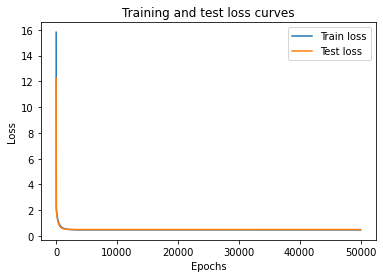

In [10]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [11]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([[-2.3194],
        [-4.4223],
        [ 0.9162]])), ('bias', tensor([2.4308]))])


Pytorch SGD Test (This is done by Chris for testing purpose)

Trained weights: tensor([ 0.0608, -2.1335,  3.8474], requires_grad=True)
Trained bias: tensor([2.8643], requires_grad=True)


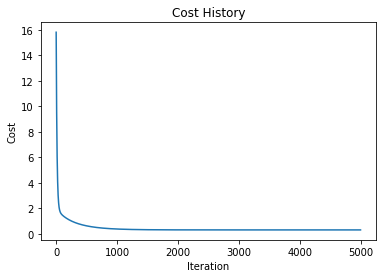

In [12]:
# Define the learning rate and number of epochs
learning_rate = 0.01
num_epochs = 5000

# Define the number of features
num_features = X_train_tensor.size()[1]

# Define the model parameters (weights and bias)
w = torch.zeros(num_features, dtype=torch.float, requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
cost_history = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (Vanilla Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=learning_rate)

# Perform gradient descent
for epoch in range(num_epochs):
    # Forward pass
    outputs = torch.matmul(X_train_tensor.float(), w) + b
    loss = criterion(outputs, y_train_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    cost_history.append(loss.detach().numpy())
    
#    # Print the loss every 10 epochs
#    if (epoch + 1) % 10 == 0:
#        print(f'Epoch [{epoch+1}], Loss: {loss.item():.8f}')
        

# Print learned parameters
print('Trained weights:', w)
print('Trained bias:', b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

Neural Network

Epoch [10/5000], Loss: 5.80558729
Epoch [20/5000], Loss: 2.70159173
Epoch [30/5000], Loss: 2.01851678
Epoch [40/5000], Loss: 1.87801695
Epoch [50/5000], Loss: 1.85013211
Epoch [60/5000], Loss: 1.84462583
Epoch [70/5000], Loss: 1.84347570
Epoch [80/5000], Loss: 1.84316707
Epoch [90/5000], Loss: 1.84302187
Epoch [100/5000], Loss: 1.84290969
Epoch [110/5000], Loss: 1.84280574
Epoch [120/5000], Loss: 1.84270465
Epoch [130/5000], Loss: 1.84260571
Epoch [140/5000], Loss: 1.84250903
Epoch [150/5000], Loss: 1.84241414
Epoch [160/5000], Loss: 1.84232116
Epoch [170/5000], Loss: 1.84223008
Epoch [180/5000], Loss: 1.84214079
Epoch [190/5000], Loss: 1.84205294
Epoch [200/5000], Loss: 1.84196711
Epoch [210/5000], Loss: 1.84188294
Epoch [220/5000], Loss: 1.84180057
Epoch [230/5000], Loss: 1.84171951
Epoch [240/5000], Loss: 1.84164011
Epoch [250/5000], Loss: 1.84156251
Epoch [260/5000], Loss: 1.84148622
Epoch [270/5000], Loss: 1.84141147
Epoch [280/5000], Loss: 1.84133816
Epoch [290/5000], Loss: 1.841

Epoch [2490/5000], Loss: 1.83751643
Epoch [2500/5000], Loss: 1.83751476
Epoch [2510/5000], Loss: 1.83751309
Epoch [2520/5000], Loss: 1.83751130
Epoch [2530/5000], Loss: 1.83750963
Epoch [2540/5000], Loss: 1.83750796
Epoch [2550/5000], Loss: 1.83750629
Epoch [2560/5000], Loss: 1.83750463
Epoch [2570/5000], Loss: 1.83750308
Epoch [2580/5000], Loss: 1.83750153
Epoch [2590/5000], Loss: 1.83749998
Epoch [2600/5000], Loss: 1.83749831
Epoch [2610/5000], Loss: 1.83749676
Epoch [2620/5000], Loss: 1.83749533
Epoch [2630/5000], Loss: 1.83749378
Epoch [2640/5000], Loss: 1.83749223
Epoch [2650/5000], Loss: 1.83749068
Epoch [2660/5000], Loss: 1.83748949
Epoch [2670/5000], Loss: 1.83748794
Epoch [2680/5000], Loss: 1.83748639
Epoch [2690/5000], Loss: 1.83748507
Epoch [2700/5000], Loss: 1.83748388
Epoch [2710/5000], Loss: 1.83748245
Epoch [2720/5000], Loss: 1.83748102
Epoch [2730/5000], Loss: 1.83747971
Epoch [2740/5000], Loss: 1.83747852
Epoch [2750/5000], Loss: 1.83747697
Epoch [2760/5000], Loss: 1.8

Epoch [4870/5000], Loss: 1.83736634
Epoch [4880/5000], Loss: 1.83736622
Epoch [4890/5000], Loss: 1.83736598
Epoch [4900/5000], Loss: 1.83736575
Epoch [4910/5000], Loss: 1.83736563
Epoch [4920/5000], Loss: 1.83736563
Epoch [4930/5000], Loss: 1.83736515
Epoch [4940/5000], Loss: 1.83736515
Epoch [4950/5000], Loss: 1.83736491
Epoch [4960/5000], Loss: 1.83736479
Epoch [4970/5000], Loss: 1.83736467
Epoch [4980/5000], Loss: 1.83736432
Epoch [4990/5000], Loss: 1.83736432
Epoch [5000/5000], Loss: 1.83736408
hidden.weight: tensor([[-0.2662, -0.4540,  0.5021],
        [ 0.0963,  0.2449,  0.2729],
        [-0.0761,  0.4558, -0.3306],
        [-0.0241, -0.4189,  0.1960],
        [-0.2481,  0.1583, -0.1023],
        [ 0.4078, -0.3271, -0.2392],
        [-0.3968,  0.5036,  0.2196],
        [ 0.5233, -0.4874, -0.5595],
        [-0.5005, -0.4174,  0.2332],
        [ 0.1544,  0.4665, -0.2693]])
hidden.bias: tensor([-0.3561,  0.4448, -0.1131,  0.3651, -0.1193,  0.4928, -0.4158, -0.2763,
         0.1617, 

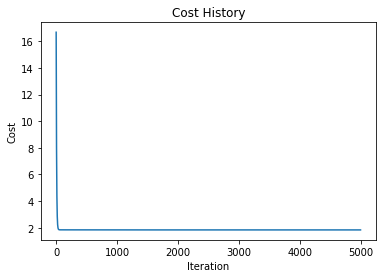

In [14]:
# Define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden_output = torch.sigmoid(self.hidden(x))
        output = self.output(hidden_output)
        return output

# Define the learning rate and number of epochs
learning_rate = 0.01
num_epochs = 5000

# Define a list to store the cost history
cost_history = []
    
# Define the dimensions of the neural network
input_size = X_train_tensor.size()[1]  # Number of input features
hidden_size = 10  # Number of hidden units
output_size = 1  # Number of output classes (1 for binary classification)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, output_size)

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (e.g., stochastic gradient descent)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Perform training
for epoch in range(num_epochs):
    # Forward pass
    output = model(X_train_tensor.float())
    loss = criterion(output, y_train_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    cost_history.append(loss.item())
    
    # Print the loss every 100 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
        
# Print learned parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()